# Meet the Waldos  
### *An R–CNN Project in Two Parts*

## Logistics  

**Project Members**

- Matt Galindo  
- Sepehr Akbari  

**Course / Assignment**

- CSCI&nbsp;450: Computer Vision and Machine Learning – *Project 2*  

**Datasets**

| Alias | Full name | Author | Source |
|-------|-----------|--------|--------|
| **Cellwaldo** | Lung and Colon Cancer Histology | Larxel | Kaggle |
| **Realwaldo** | FindWaldo | Agnar Bjørstad | GitHub |

- <https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images>  
- <https://github.com/agnarbjoernstad/FindWaldo>

## Overview

### Objective  
Build a **Region‑Based Convolutional Network (R‑CNN)** that out‑performs existing models at detecting Waldo in the classic *Where’s Waldo?* search‑book.

### Previous approaches  
- Classical feature & template matching
- Haar cascades / face detectors – poor due to stylised face  
- Early R‑CNN baselines  
- “Head‑only” R‑CNN (64 × 64 faces, binary ± Waldo)  


### Our approach  
We tackle the *low‑data* bottleneck:  

1. **Synthetic pre‑training** – generate thousands of *Cellwaldo* images and train YOLO‑v8 from scratch.  
2. **Transfer‑learning fine‑tune** – freeze most weights and retrain on *real* Waldo pages.

![waldo_example.jpg](outputs/waldo_example.jpg)

## Part 1 – Cell Waldo

### Method  
Create a synthetic dataset by pasting an artificial “cell‑Waldo” on histology slides, record bounding boxes, and train YOLO‑v8 for 30 epochs.

![colonca10.jpeg](outputs/colonca10.jpeg)

### Environment & libraries

In [ ]:
# create clean environment
conda create -n cellwaldo python=3.11 -y
conda activate cellwaldo

# core deps
pip install opencv-python glob pillow numpy pandas tqdm albumentations==1.4.0

# detector
pip install ultralytics==8.3.115

### `make_cell_waldo.py`  – generate the Waldo cell sprite

In [ ]:
import cv2, numpy as np
from pathlib import Path

def make_cell_waldo(out_path="cell_waldo.png",
                    radius=40,
                    cytoplasm_color=(175,125,255),   # light‑purple (BGR)
                    nucleus_color=(60,0,140)):       # dark‑purple (BGR)
    r = radius
    png = np.zeros((2*r, 2*r, 4), np.uint8)          # RGBA canvas

    # striped cytoplasm
    for i in range(-r, r, 8):
        cv2.line(png, (0, i+r), (2*r, i+r), cytoplasm_color+(255,), 5)

    # filled cytoplasm
    cv2.circle(png, (r,r), r-2, cytoplasm_color+(255,), -1)
    # nucleus + white outline
    cv2.circle(png, (r,r), int(r*0.55), nucleus_color+(255,), -1)
    cv2.circle(png, (r,r), int(r*0.55), (255,255,255,0), 3)

    Path(out_path).parent.mkdir(parents=True, exist_ok=True)
    cv2.imwrite(out_path, png)
    print(f"Saved → {out_path}")

if __name__ == "__main__":
    make_cell_waldo()

![cell_waldo.png](outputs/cell_waldo.png)

### `make_synthetic.py`  – build 8 k synthetic training images

In [ ]:
import albumentations as A, cv2, numpy as np, random, os
from glob import glob
from pathlib import Path
from tqdm import tqdm

BG_DIR = "histology_backgrounds"
WALDO_PATH = "cell_waldo.png"
OUT = Path("synthetic_dataset")
N = 8000
IMG = 640

(OUT/"images").mkdir(parents=True, exist_ok=True)
(OUT/"labels").mkdir(parents=True, exist_ok=True)

bg_paths = glob(os.path.join(BG_DIR, "*"))
waldo_rgba = cv2.imread(WALDO_PATH, cv2.IMREAD_UNCHANGED)

waldo_aug = A.Compose([
    A.Rotate(limit=180, border_mode=cv2.BORDER_CONSTANT, value=0, p=0.9),
    A.RandomScale(scale_limit=0.6, p=1.0),
    A.GaussNoise(var_limit=(5,30), p=0.4)
])

for i in tqdm(range(N)):
    bg = cv2.imread(random.choice(bg_paths))
    h,w = bg.shape[:2]
    c = min(h,w)
    y0 = random.randint(0,h-c); x0 = random.randint(0,w-c)
    patch = cv2.resize(bg[y0:y0+c, x0:x0+c], (IMG,IMG))

    waldo = waldo_aug(image=waldo_rgba)["image"]
    wh,ww = waldo.shape[:2]
    x = random.randint(0, IMG-ww-1)
    y = random.randint(0, IMG-wh-1)

    alpha = waldo[...,3:]/255.0
    patch[y:y+wh, x:x+ww] = (alpha*waldo[...,:3] + (1-alpha)*patch[y:y+wh,x:x+ww]).astype(np.uint8)

    name = f"cellwaldo_{i:05d}.jpg"
    cv2.imwrite(str(OUT/'images'/name), patch)

    cx,cy = (x+ww/2)/IMG, (y+wh/2)/IMG
    bw,bh = ww/IMG, wh/IMG
    with open(OUT/'labels'/name.replace('.jpg','.txt'),'w') as f:
        f.write(f"0 {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f}\n")

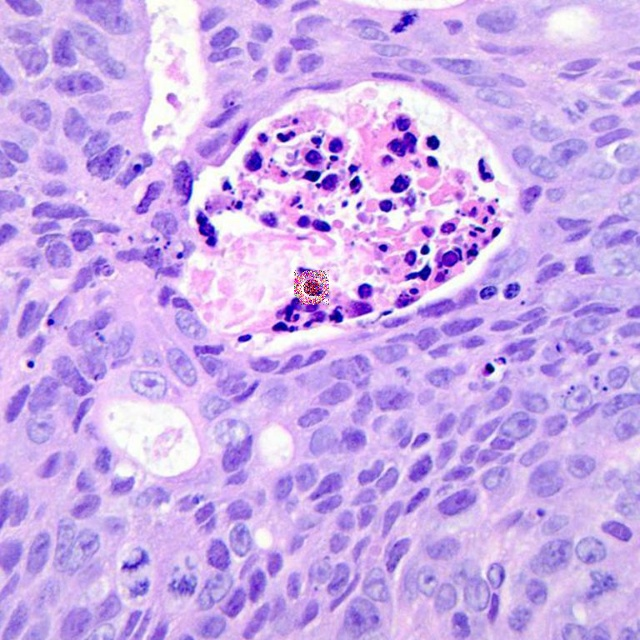
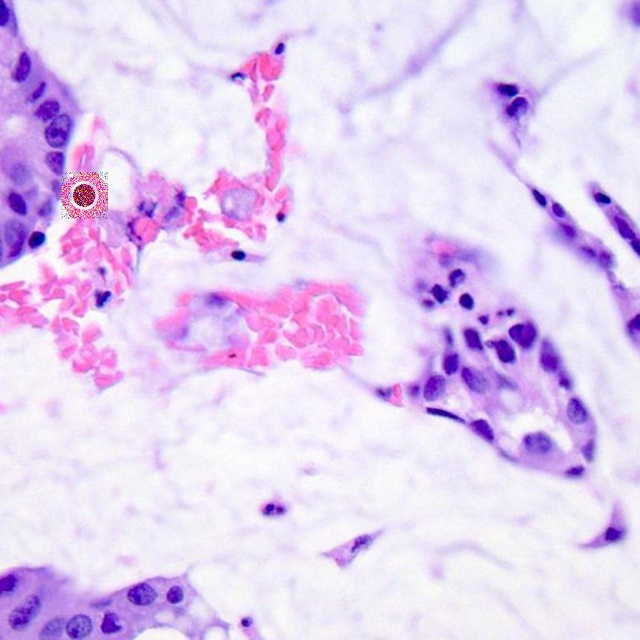

### YOLO configuration (`cellwaldo.yaml`)

In [ ]:
path: synthetic_dataset
train: images
val: images
nc: 1
names: ["cell_waldo"]

### Train

In [ ]:
from ultralytics import YOLO
model = YOLO("yolov8n.pt")
model.train(data='cellwaldo.yaml', epochs=30, imgsz=640, lr0=1e-3, split=0.8)

### Results  

| Metric | Best | Notes |
|--------|------|-------|
| **Precision / Recall** | ~1.0 | Flat PR‑curve shows easy task |
| **mAP<sub>50</sub>** | 1.0 | Perfect on validation |
| **Confusion matrix** | No false‑positives |  

> High scores confirm the sprite is trivially separable; future work could add *negative* classes or make Waldo harder to spot.

### *Sample Image:*

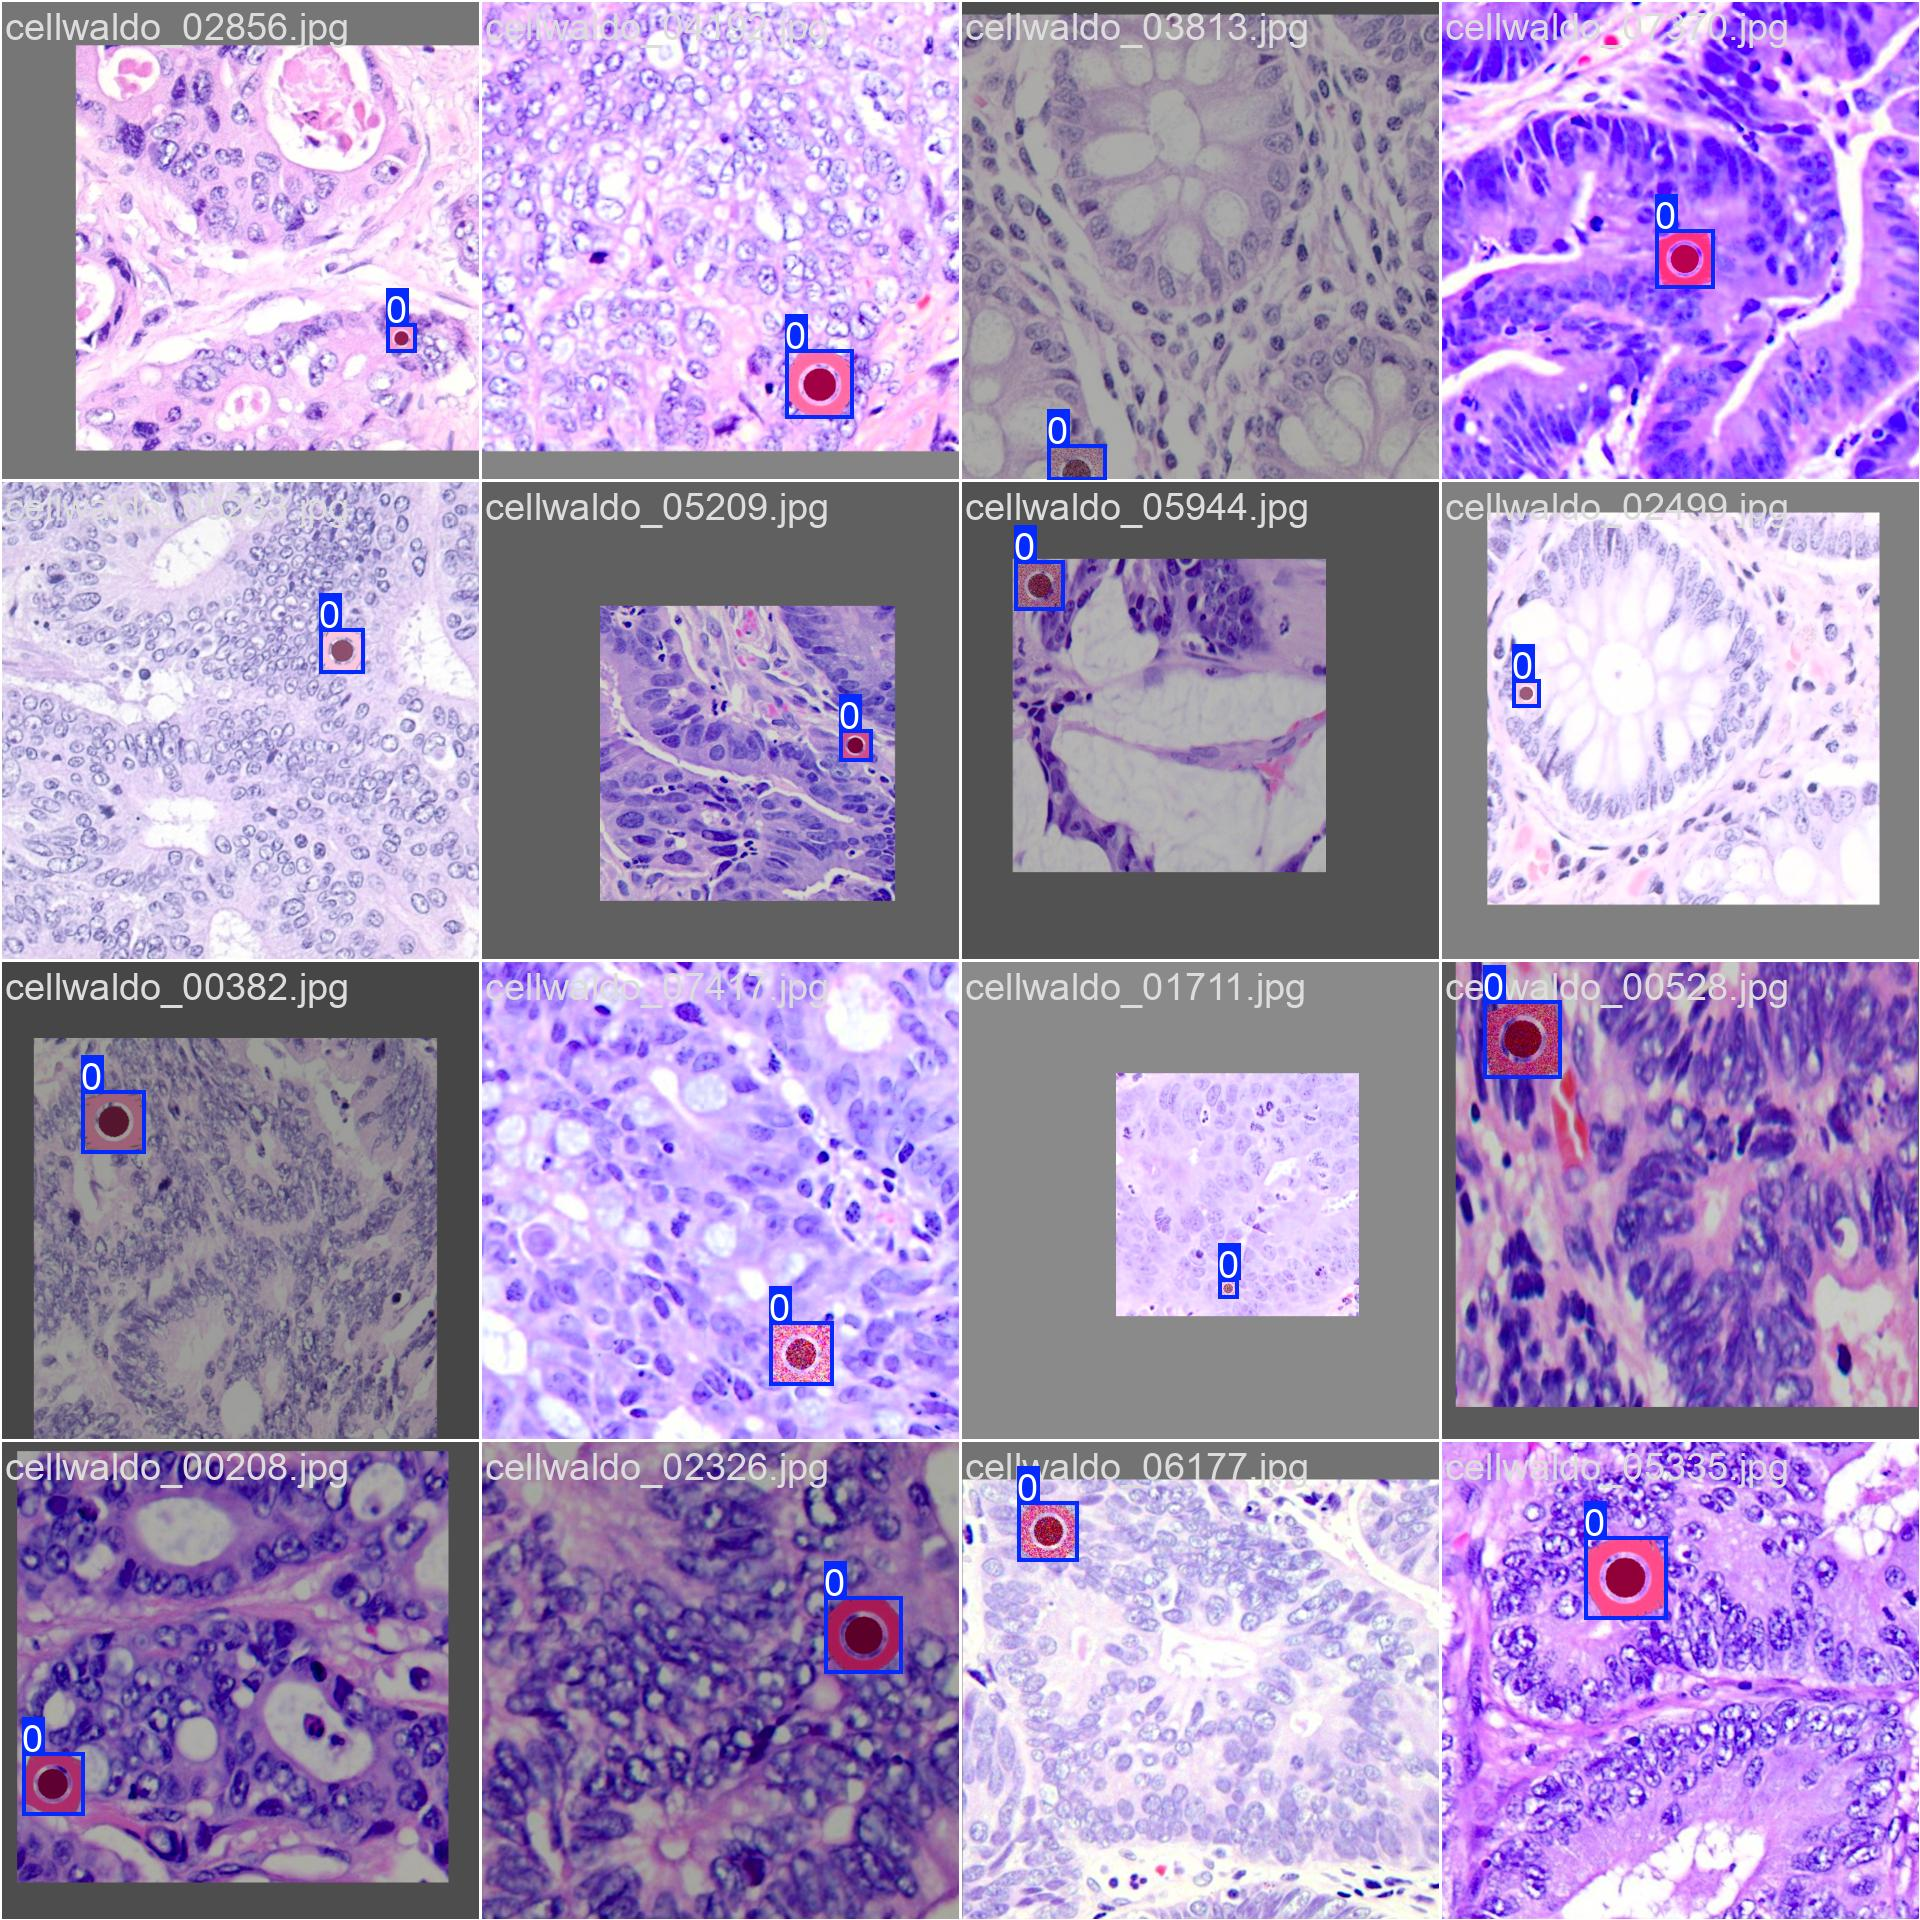

### *Train & Validation Loss:*

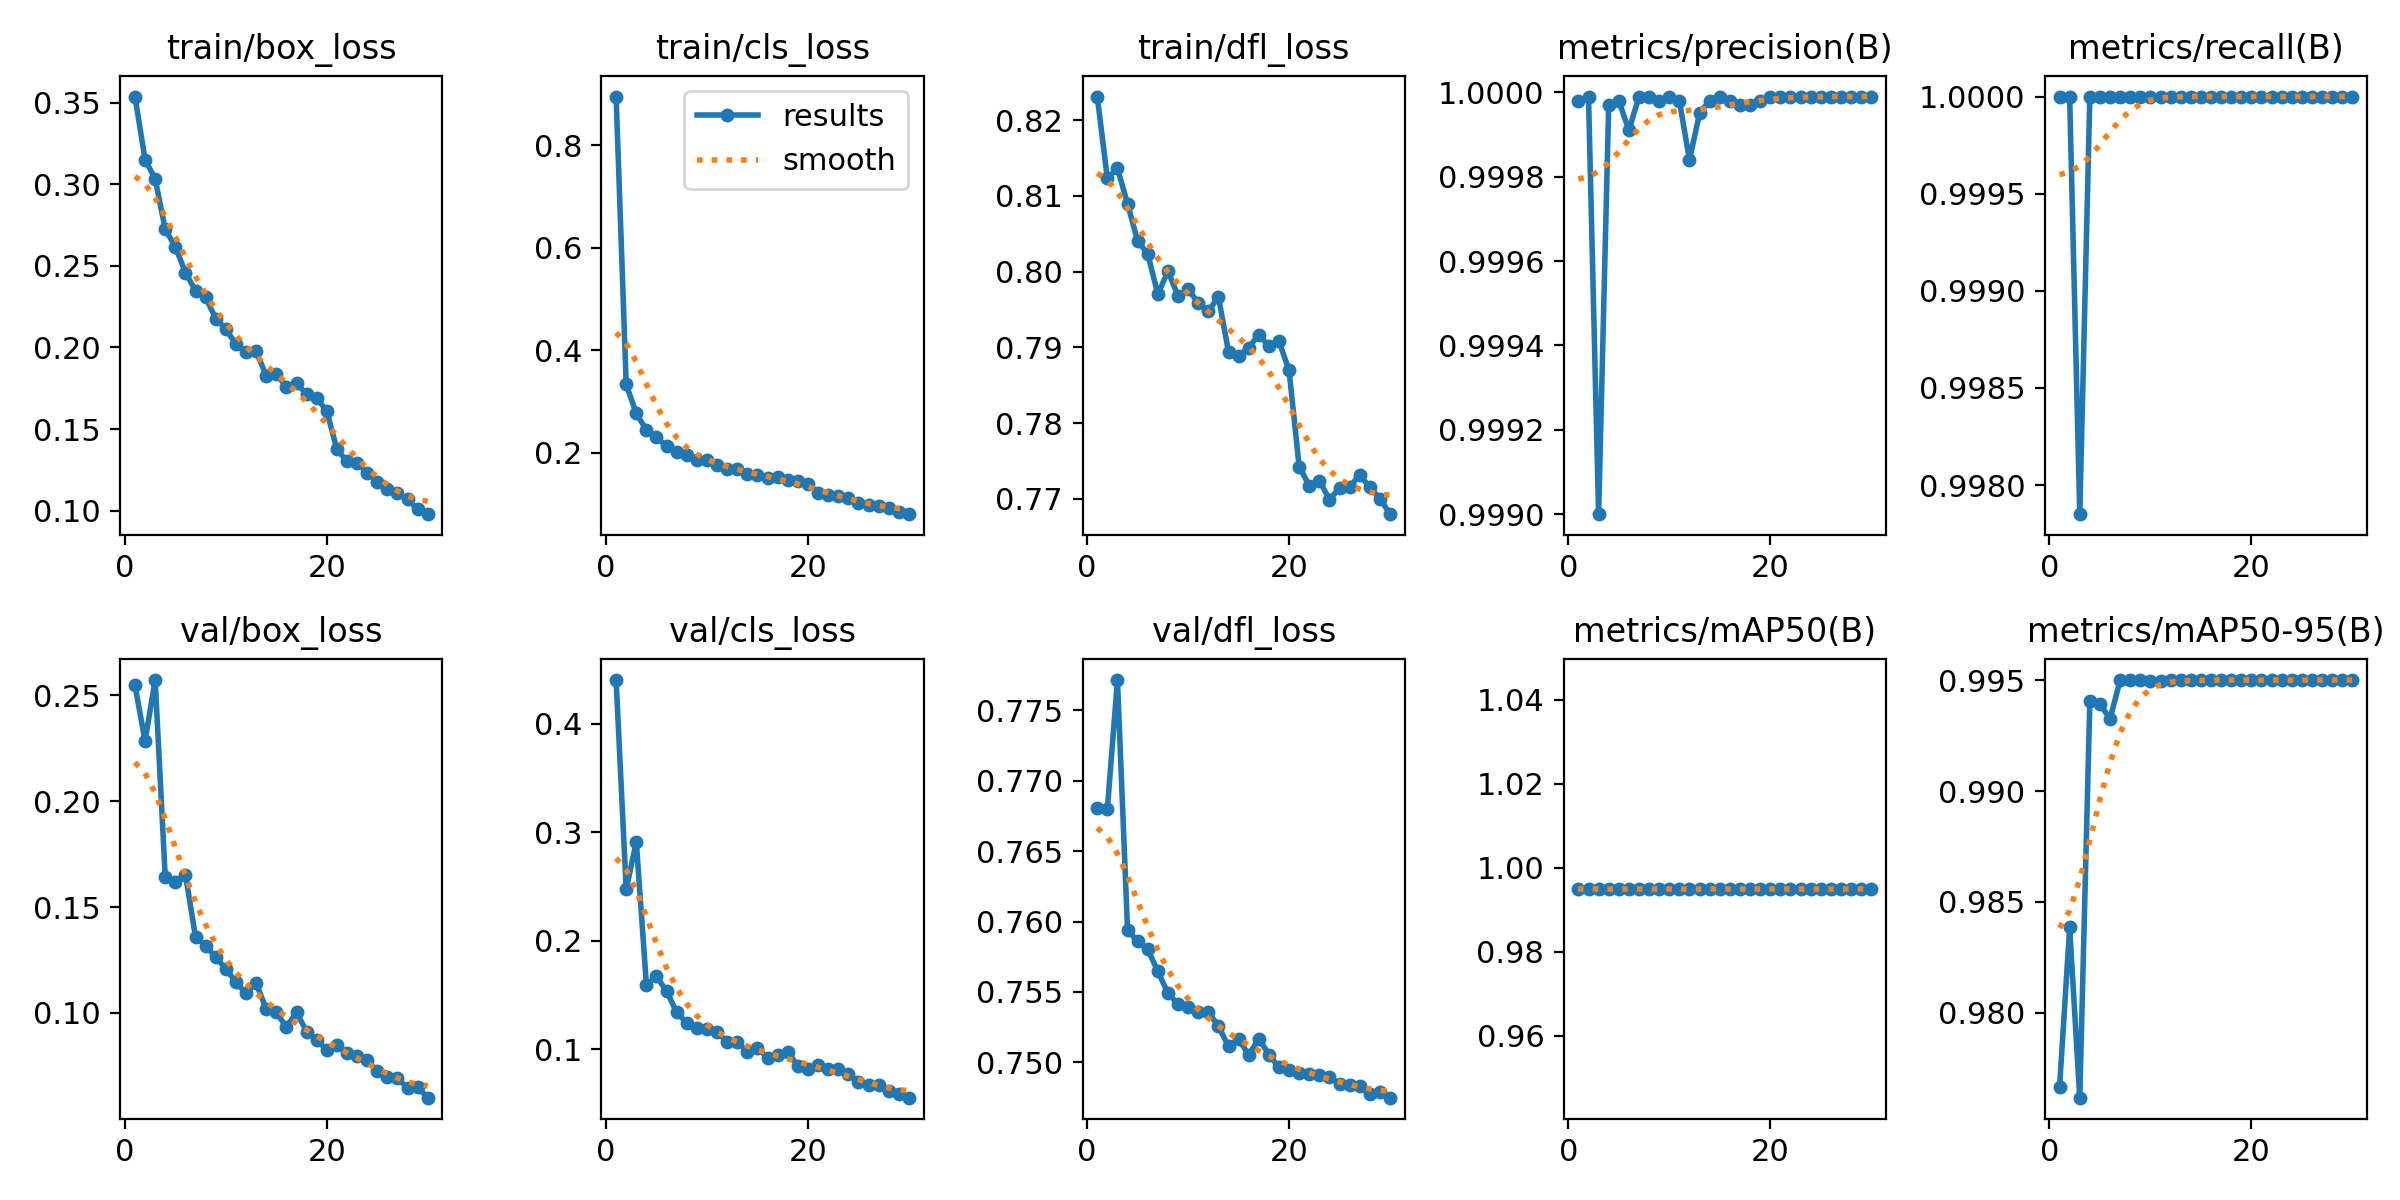

### *Precision, Recall / Condifence Curves:*

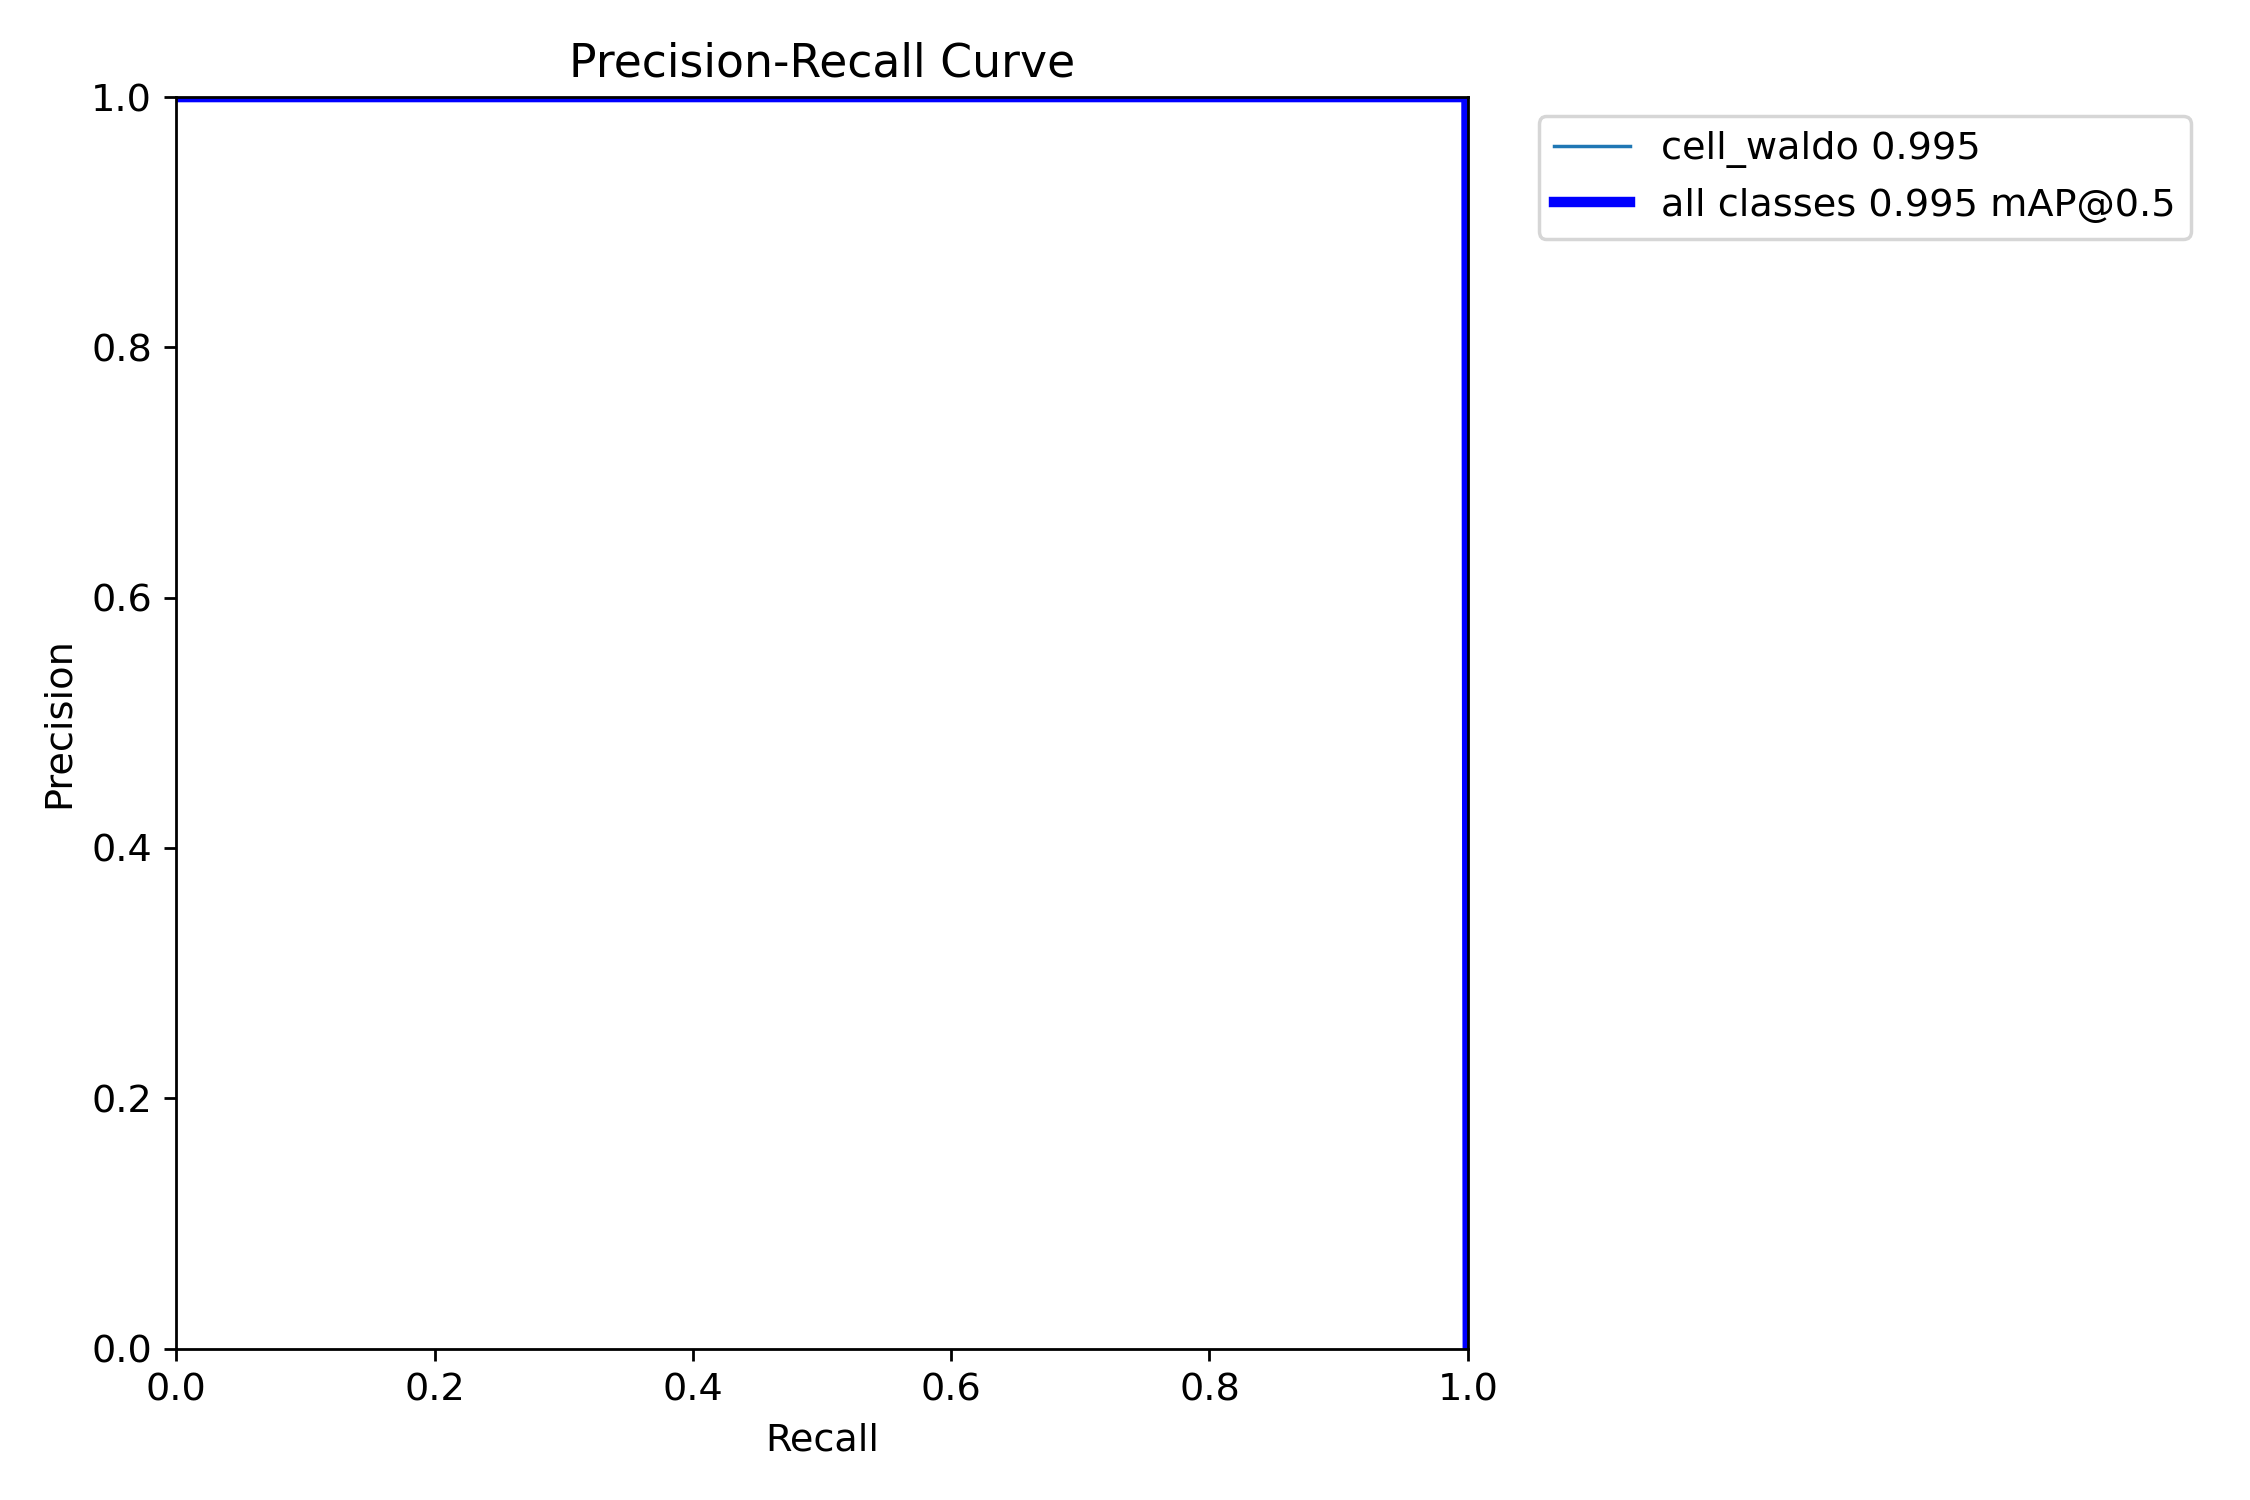

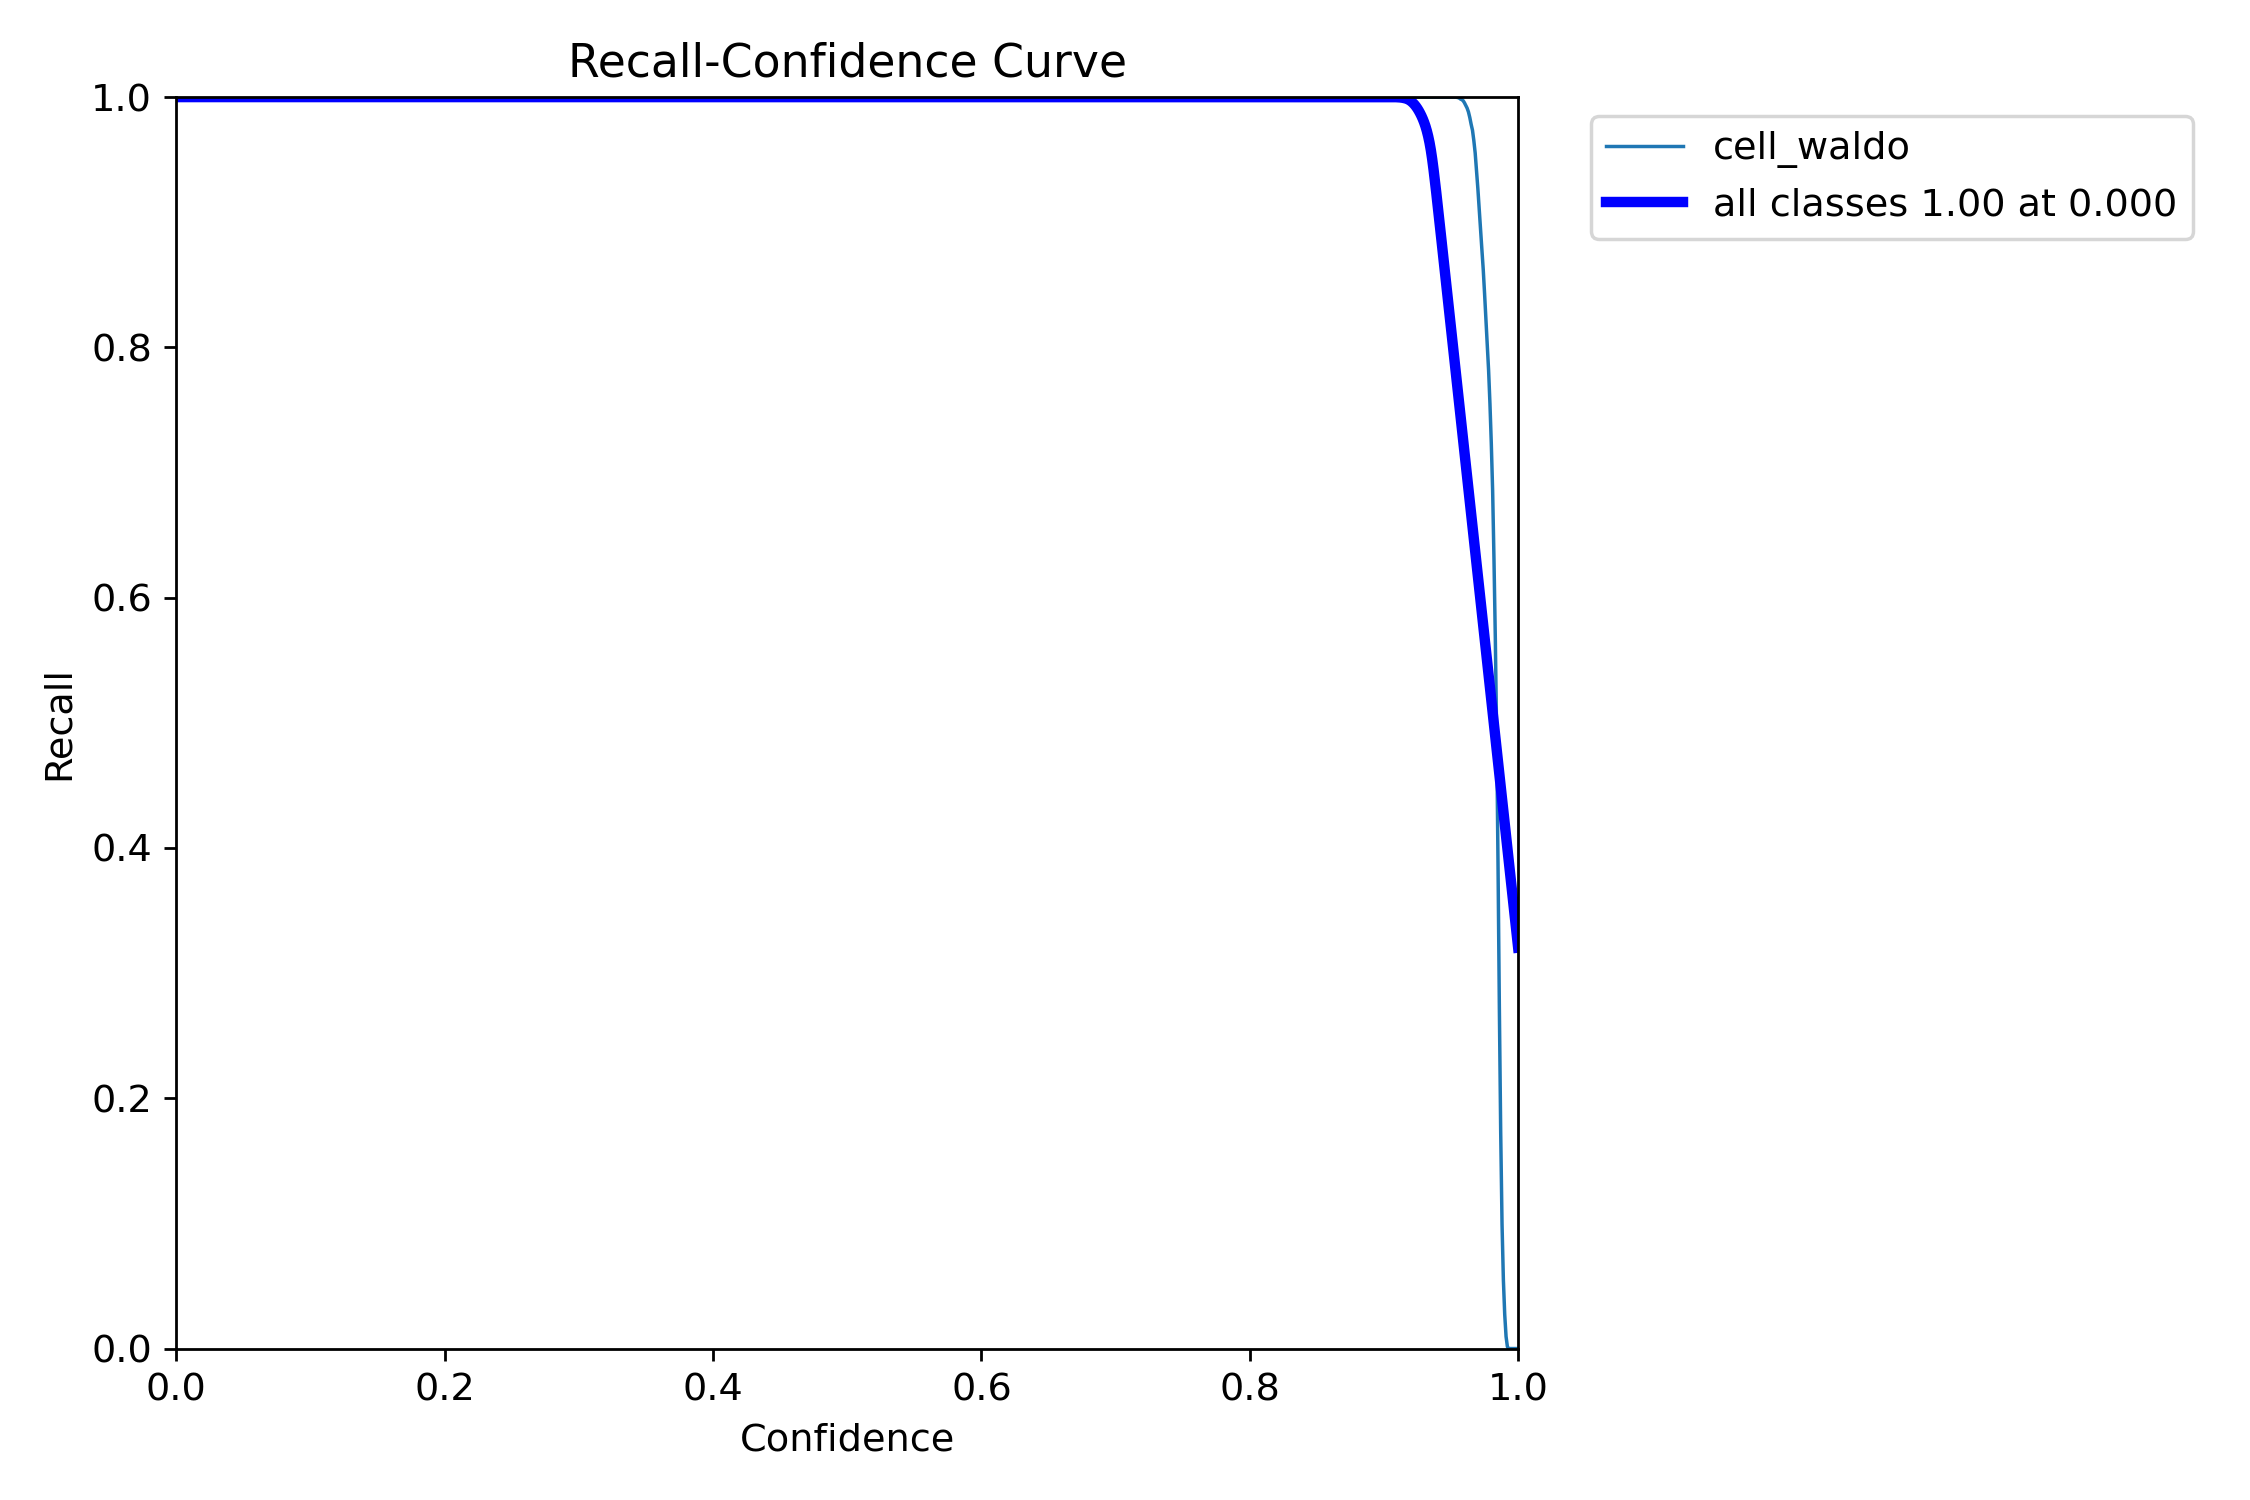

### *Confusion Matrix:*

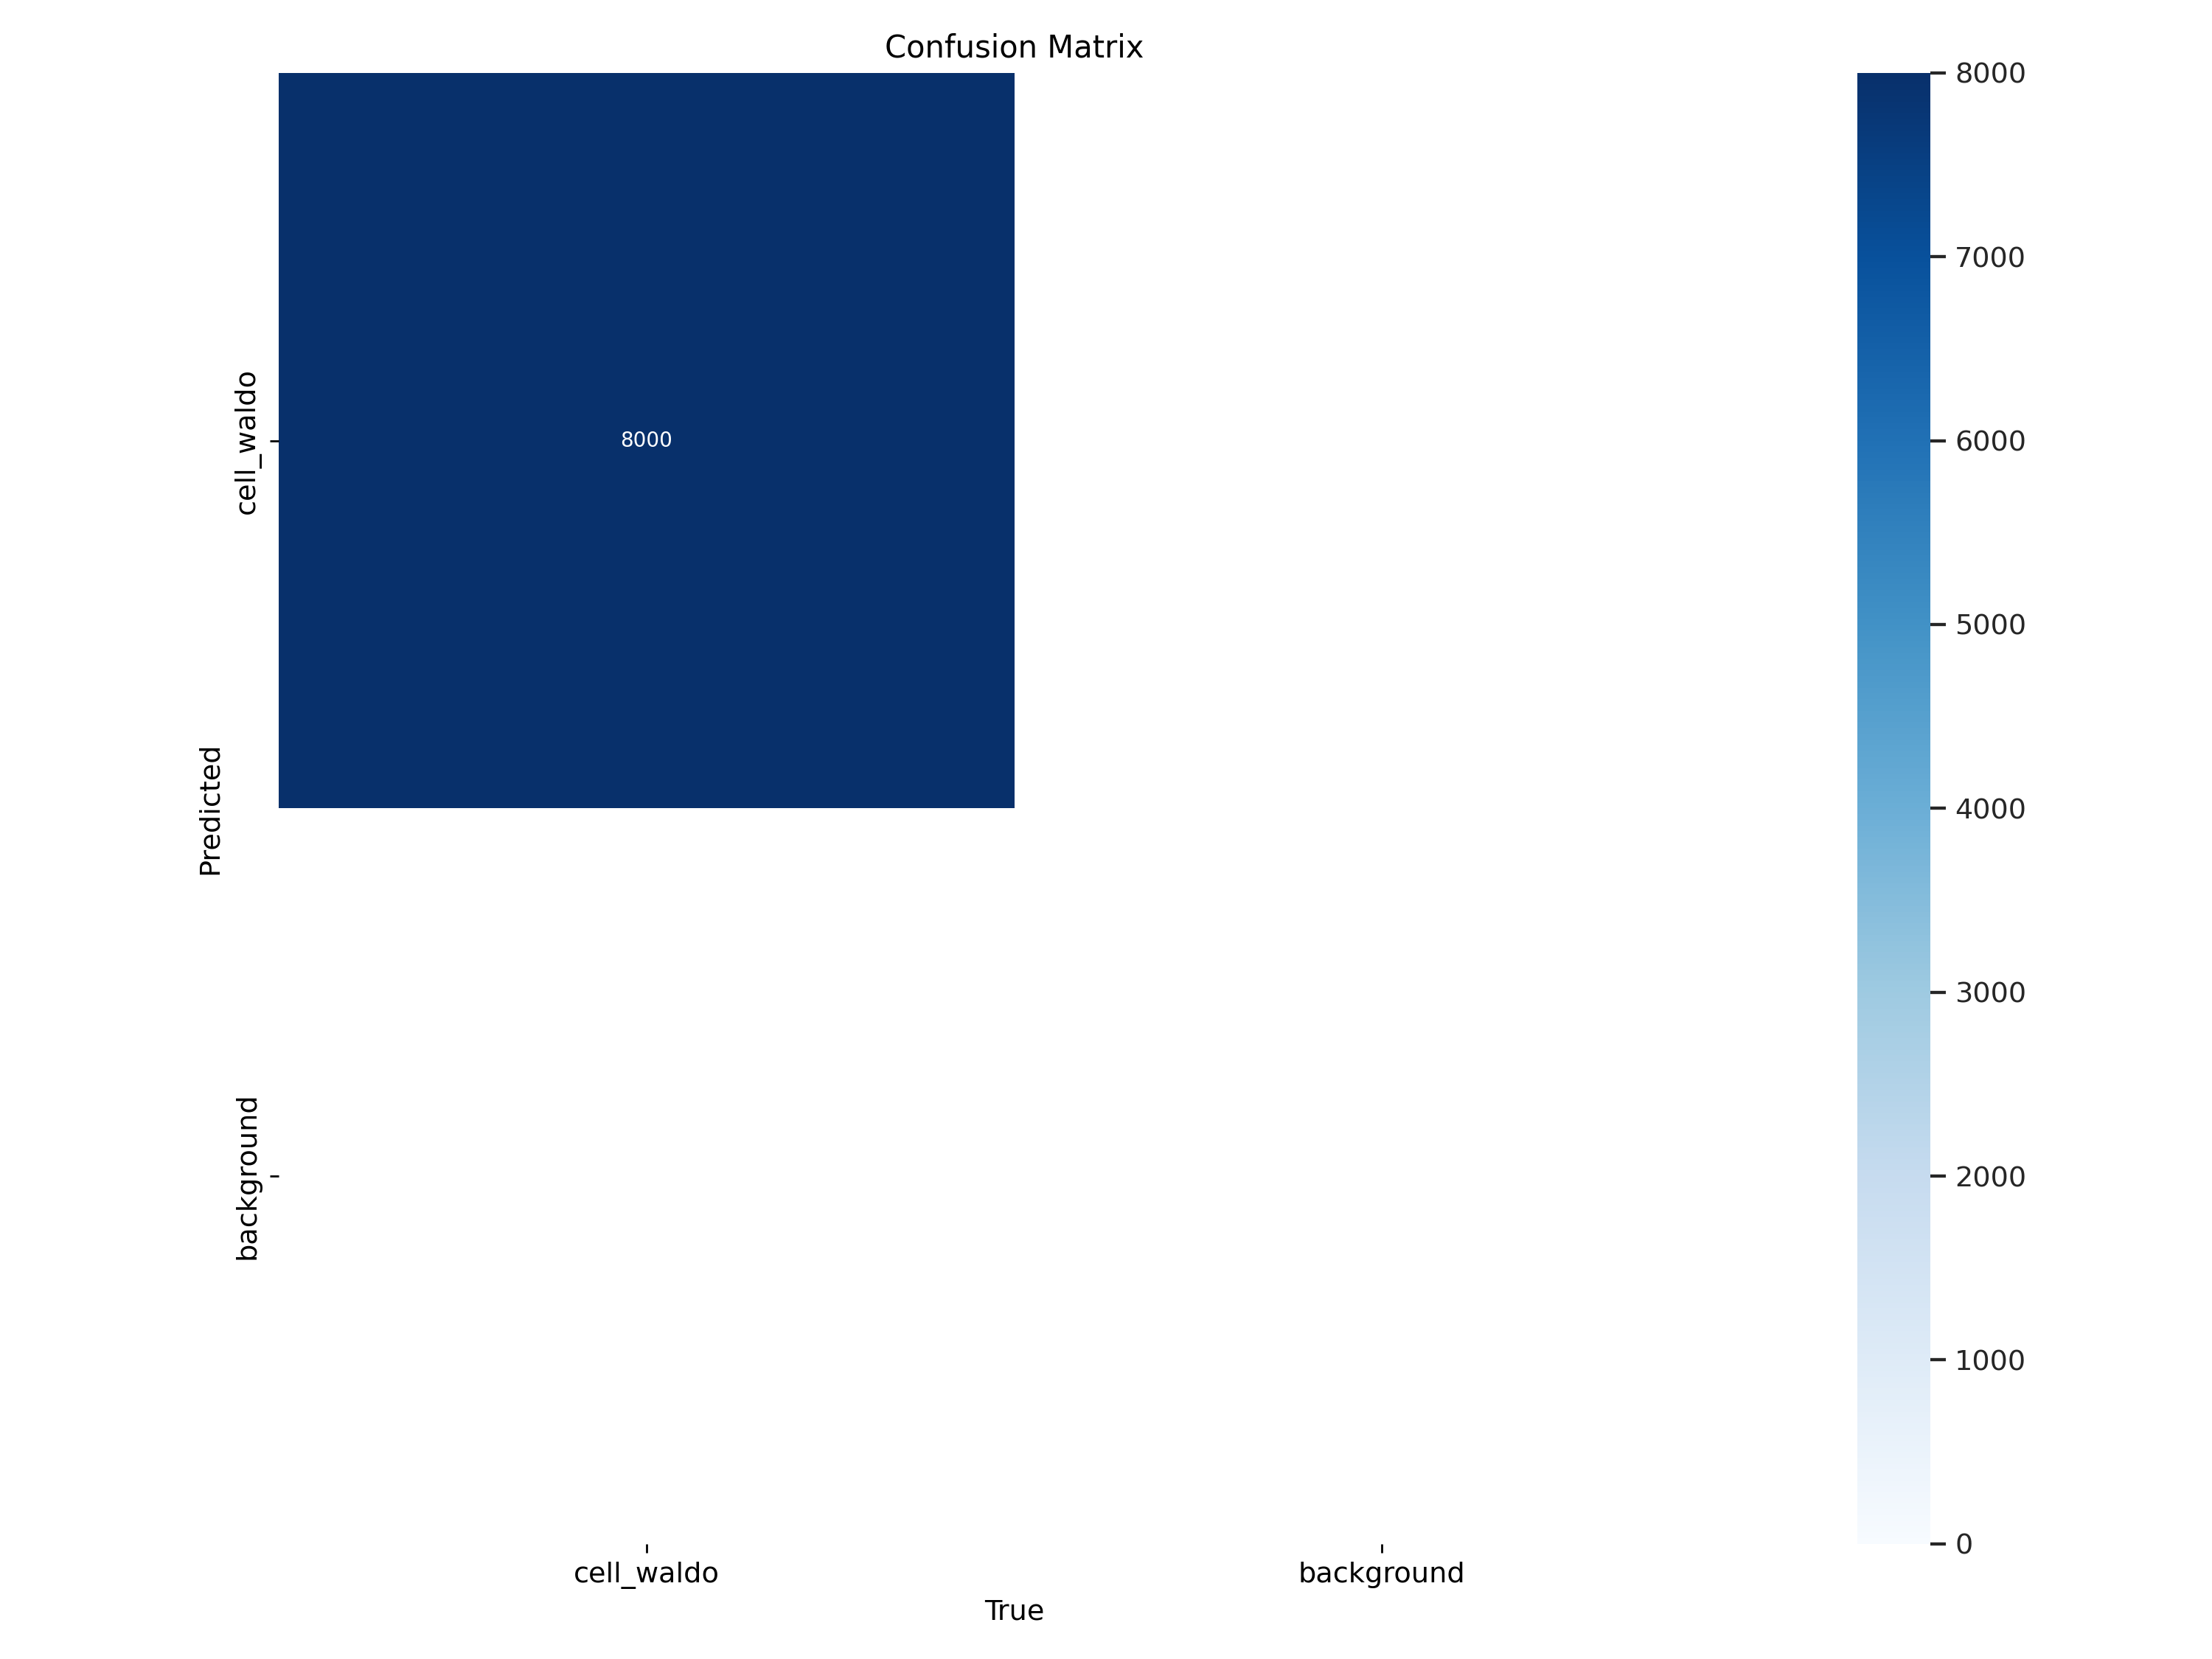

## Part 2 – Real Waldo (Transfer learning)

### Method  
Freeze the backbone learned on **Cellwaldo**, then fine‑tune on the 195 annotated *Where’s Waldo?* pages for 50 epochs.

### Extra libraries & data conversion

In [ ]:
# plus the earlier env:
pip install xmltodict

# convert VOC‑XML to YOLO‑txt & split 80/20
python convert_split.py

### `convert_split.py` snippet

In [ ]:
import xml.etree.ElementTree as ET, random, shutil, os
from pathlib import Path

ROOT = Path("FindingWaldo/object_detection/data")
XML,IMG = ROOT/"annotations", ROOT/"images"
OUT = Path("waldo_dataset")
for sub in ["images/train","images/val","labels/train","labels/val"]:
    (OUT/sub).mkdir(parents=True, exist_ok=True)

xmls = list(XML.glob("*.xml")); random.shuffle(xmls)
split = int(0.8*len(xmls))

def voc2yolo(sz, box):
    w,h = sz
    xmin,ymin,xmax,ymax = box
    cx,cy = (xmin+xmax)/2/w, (ymin+ymax)/2/h
    bw,bh = (xmax-xmin)/w, (ymax-ymin)/h
    return cx,cy,bw,bh

for i,xp in enumerate(xmls):
    root = ET.parse(xp).getroot()
    fname = root.find("filename").text
    size  = root.find("size")
    w,h = int(size.find("width").text), int(size.find("height").text)
    box = root.find("object").find("bndbox")
    xmin,ymin,xmax,ymax = map(int,[box.find(t).text for t in ["xmin","ymin","xmax","ymax"]])
    cx,cy,bw,bh = voc2yolo((w,h),(xmin,ymin,xmax,ymax))
    subset = "train" if i<split else "val"
    shutil.copy(IMG/fname, OUT/f"images/{subset}/{fname}")
    with open(OUT/f"labels/{subset}/{fname.split('.')[0]}.txt","w") as f:
        f.write(f"0 {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f}\n")

### YOLO configuration (`waldo_real.yaml`)

In [ ]:
path: waldo_dataset
train: images/train
val: images/val
nc: 1
names: ["waldo"]

### Fine‑tune

In [ ]:
from ultralytics import YOLO
model = YOLO('runs/cellwaldo/best.pt')      # path to the sprite model
model.train(data='waldo_real.yaml',
            epochs=50, imgsz=1024, batch=4,
            lr0=3e-4, single_cls=True, patience=8)

### Results  

| Metric | Best | Epoch |
|--------|------|-------|
| mAP<sub>50</sub> | **0.456** | 50 |
| Precision | 0.749 | 39 |
| Recall | 0.755 | 11 |

Precision climbs while recall decays, indicating a *conservative* detector that prefers fewer high‑confidence boxes. See loss & PR curves in the figures above.

### *Sample Image:*

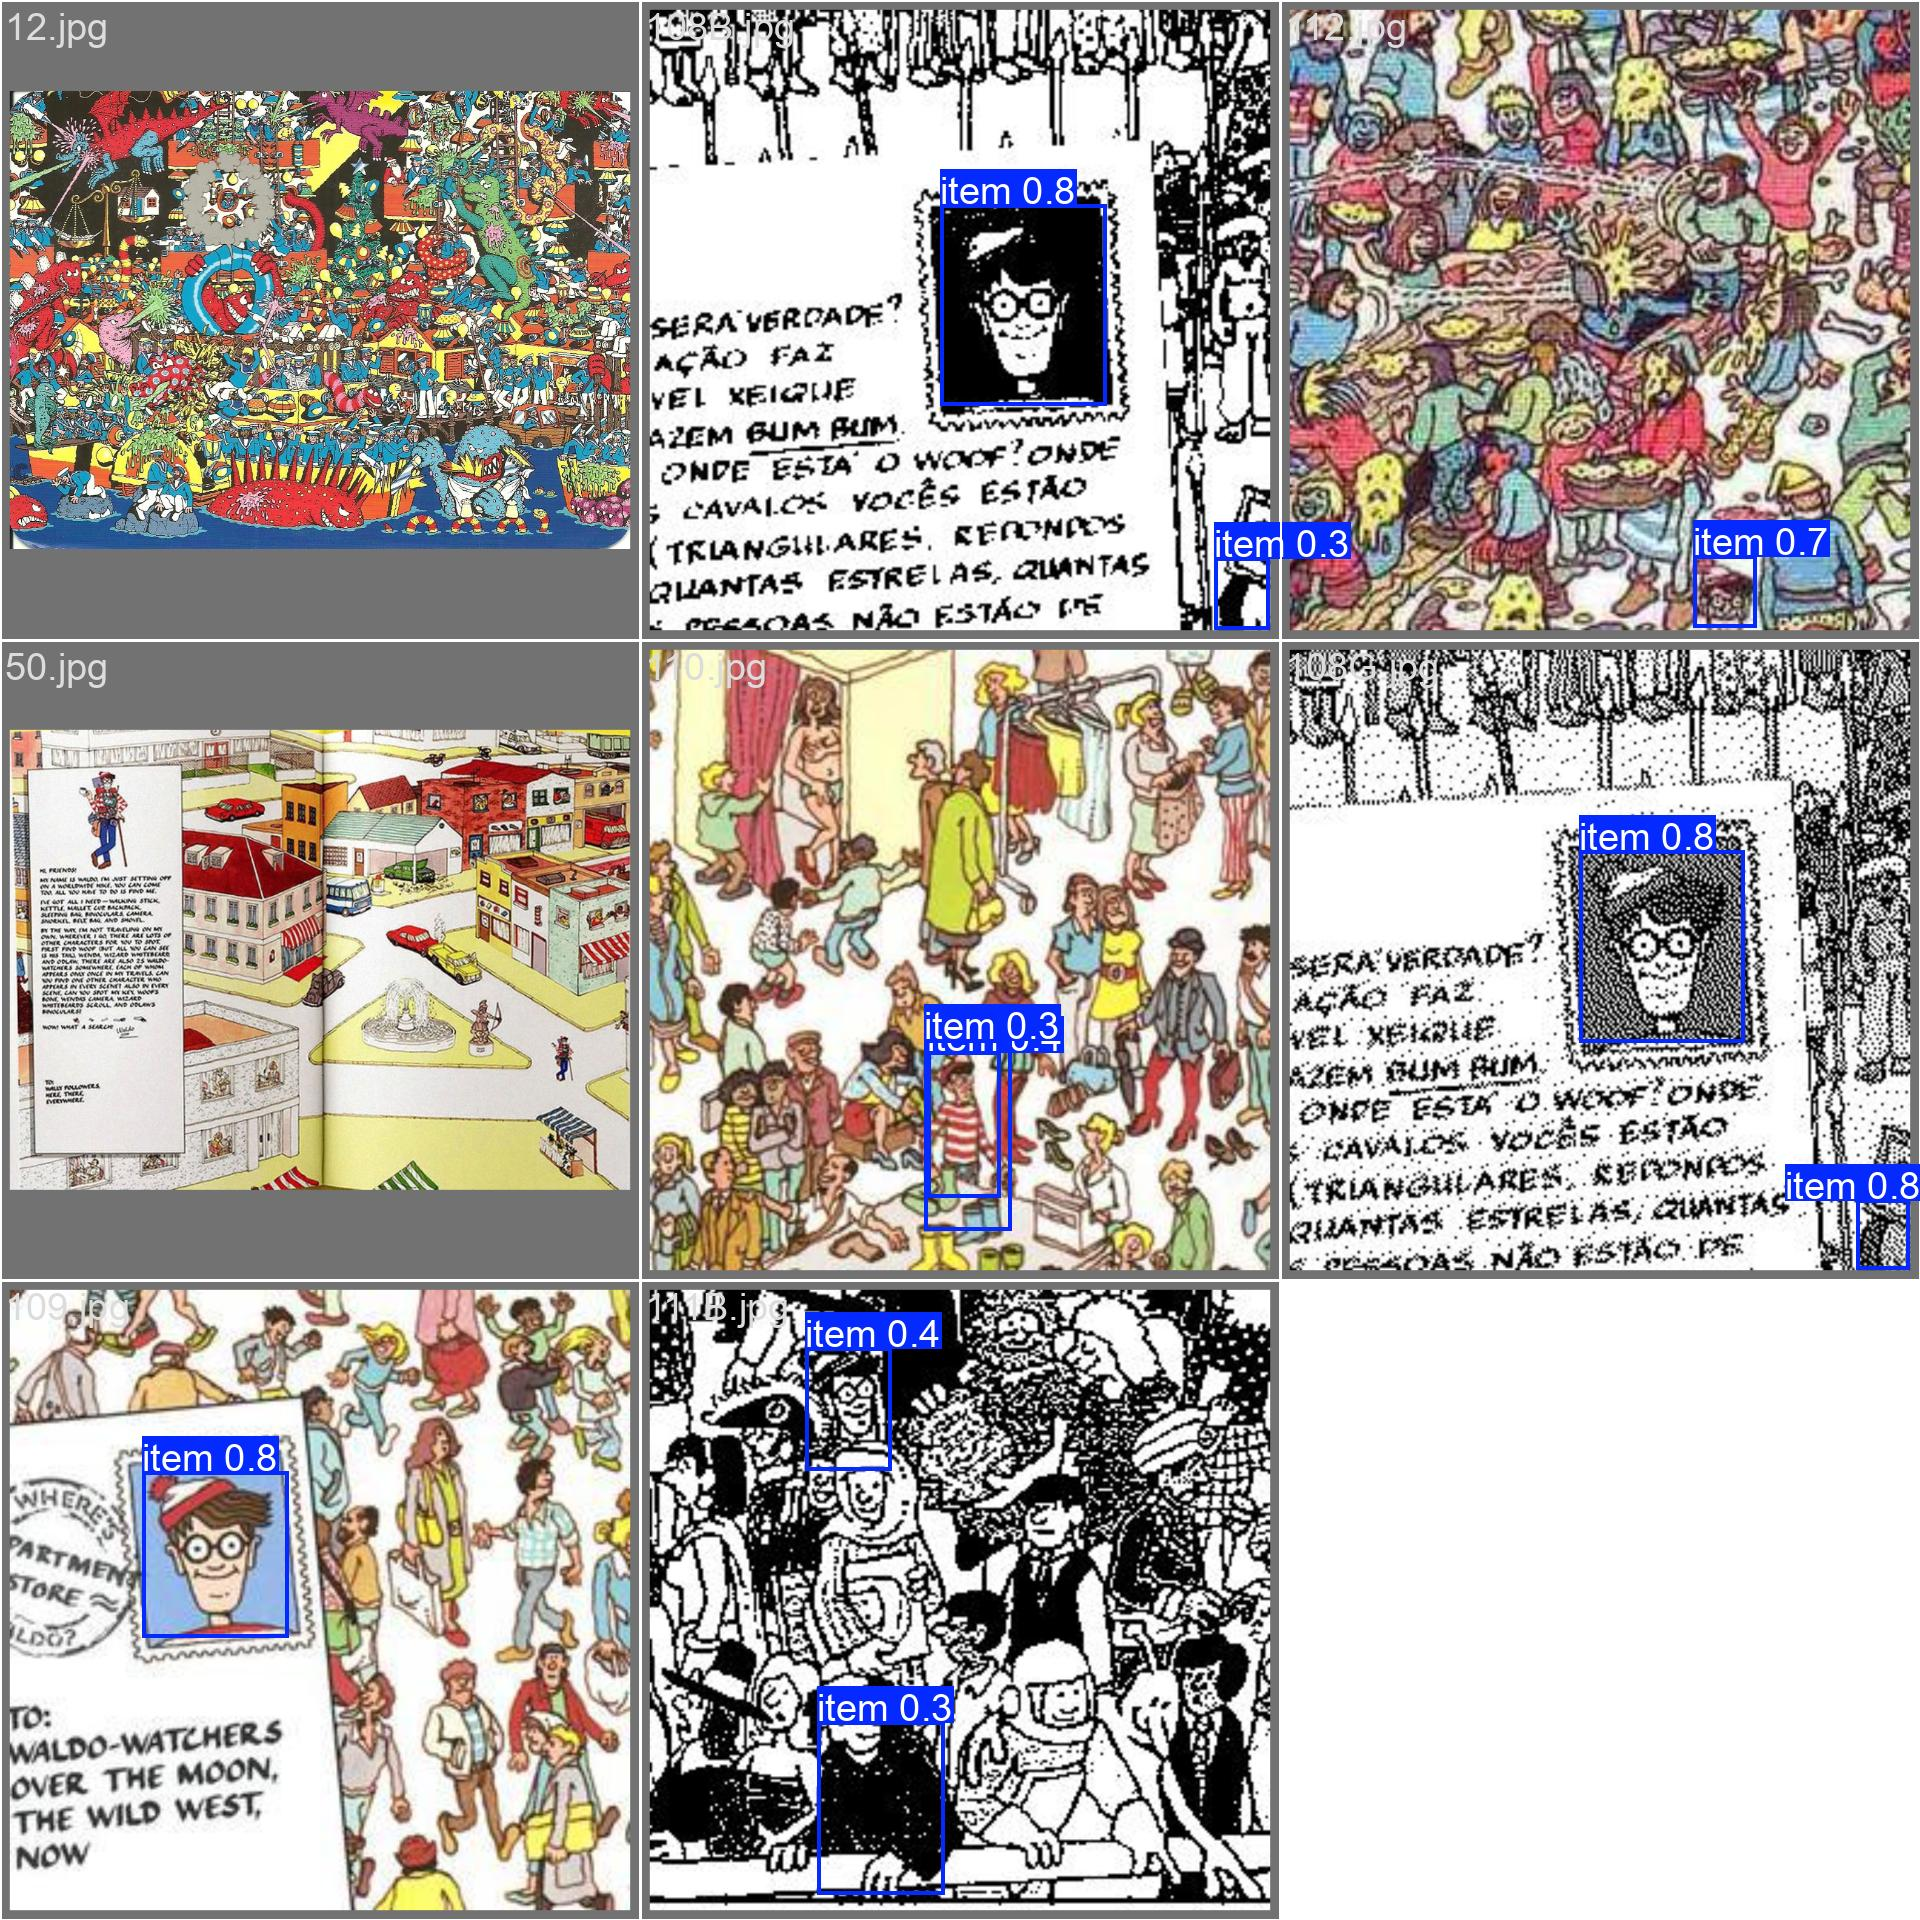

### *Train & Validation Loss:*

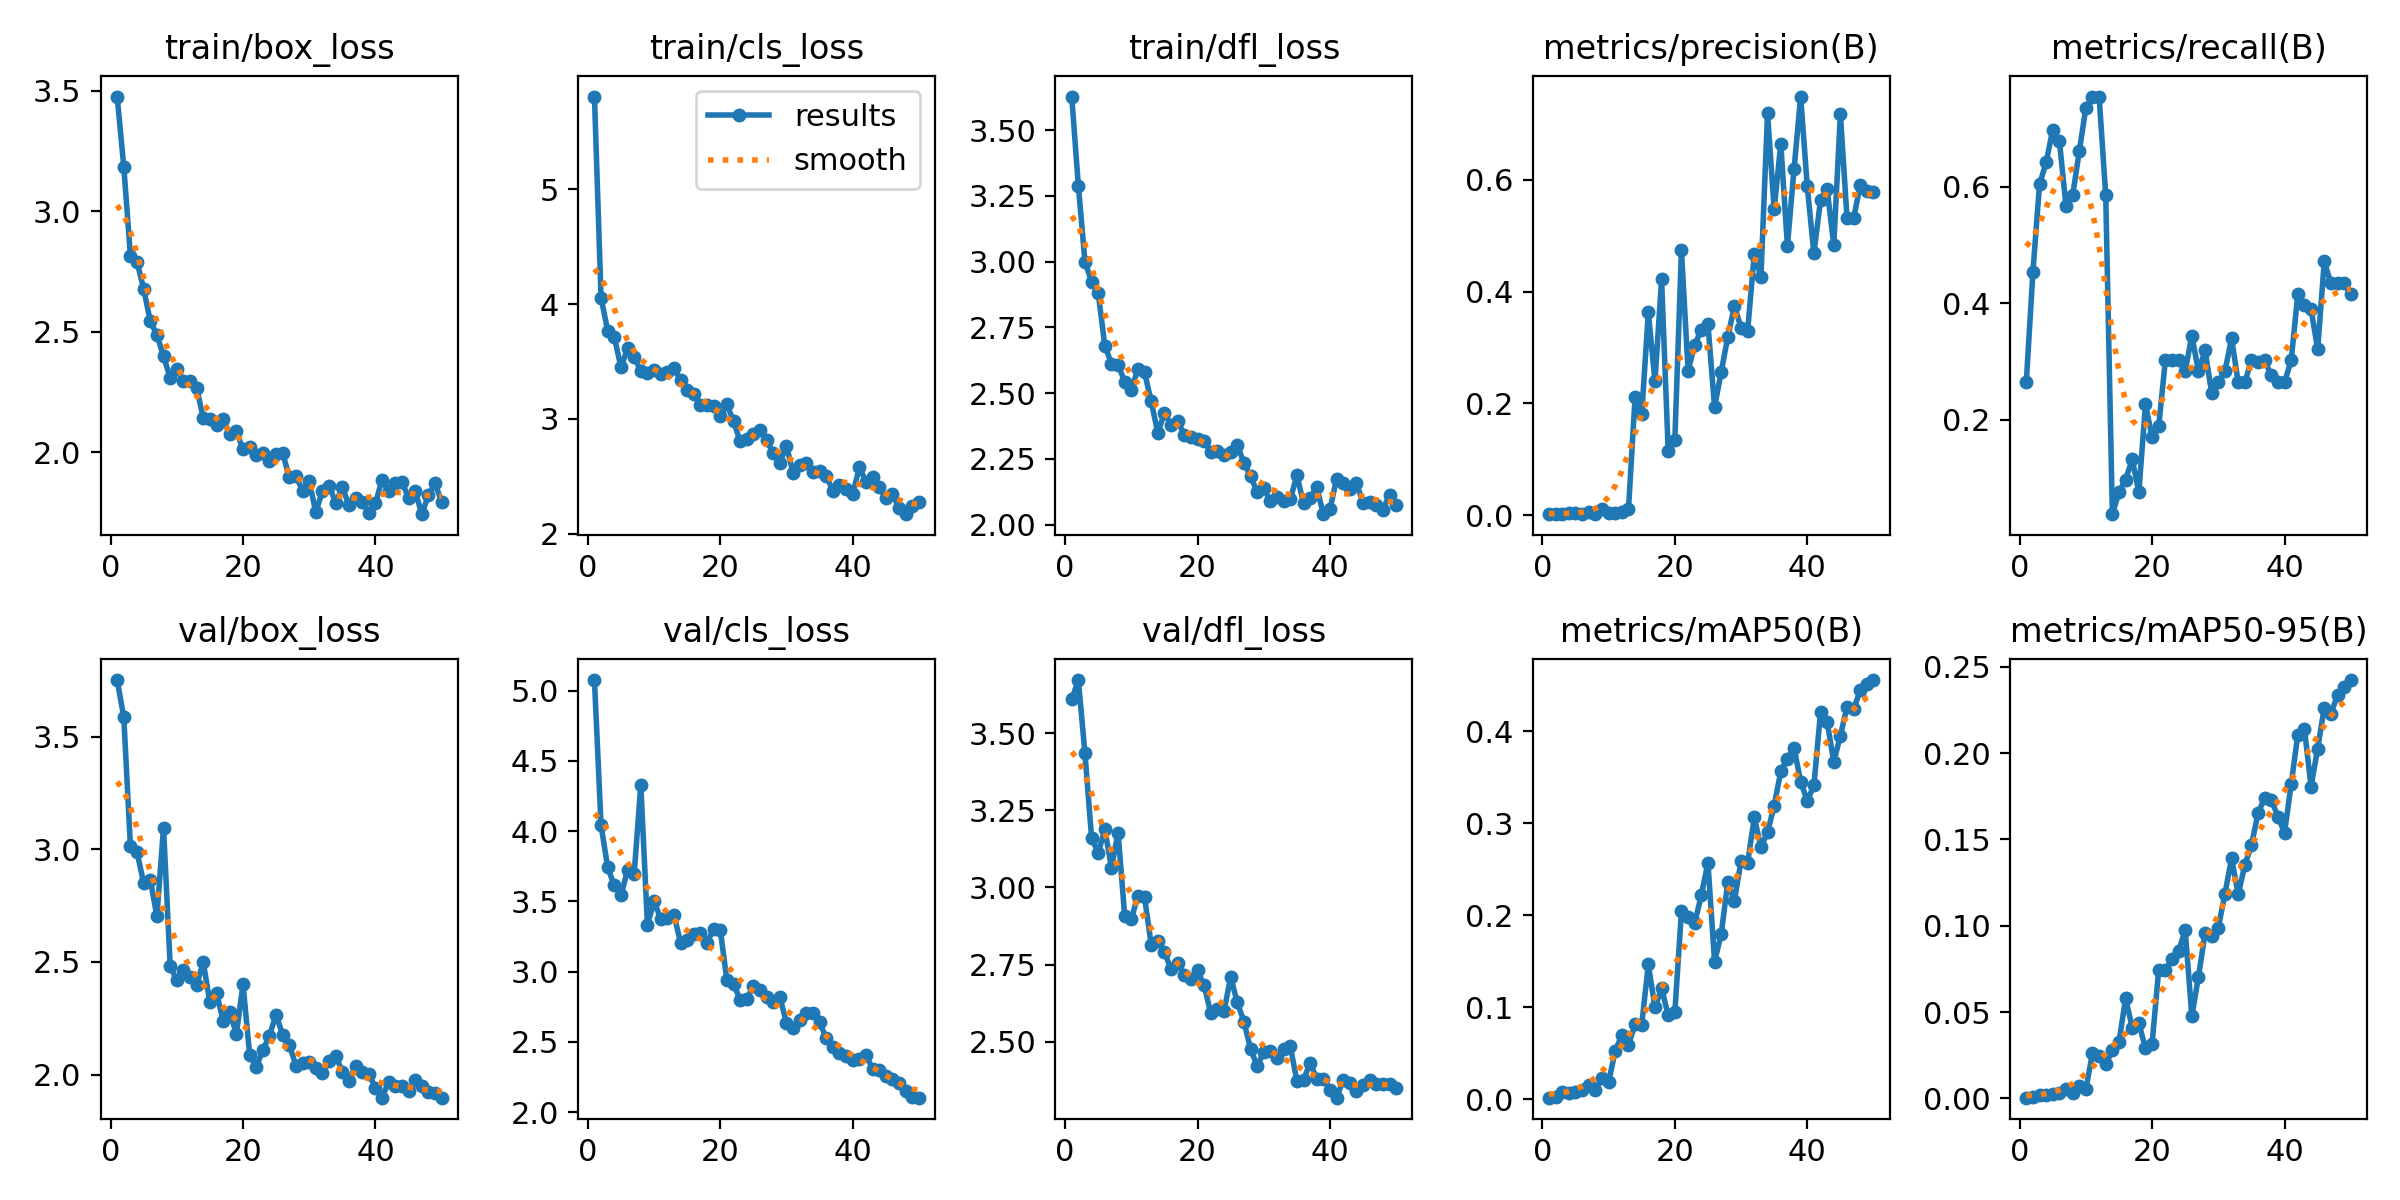

### *Precision, Recall / Confidence Curves:*

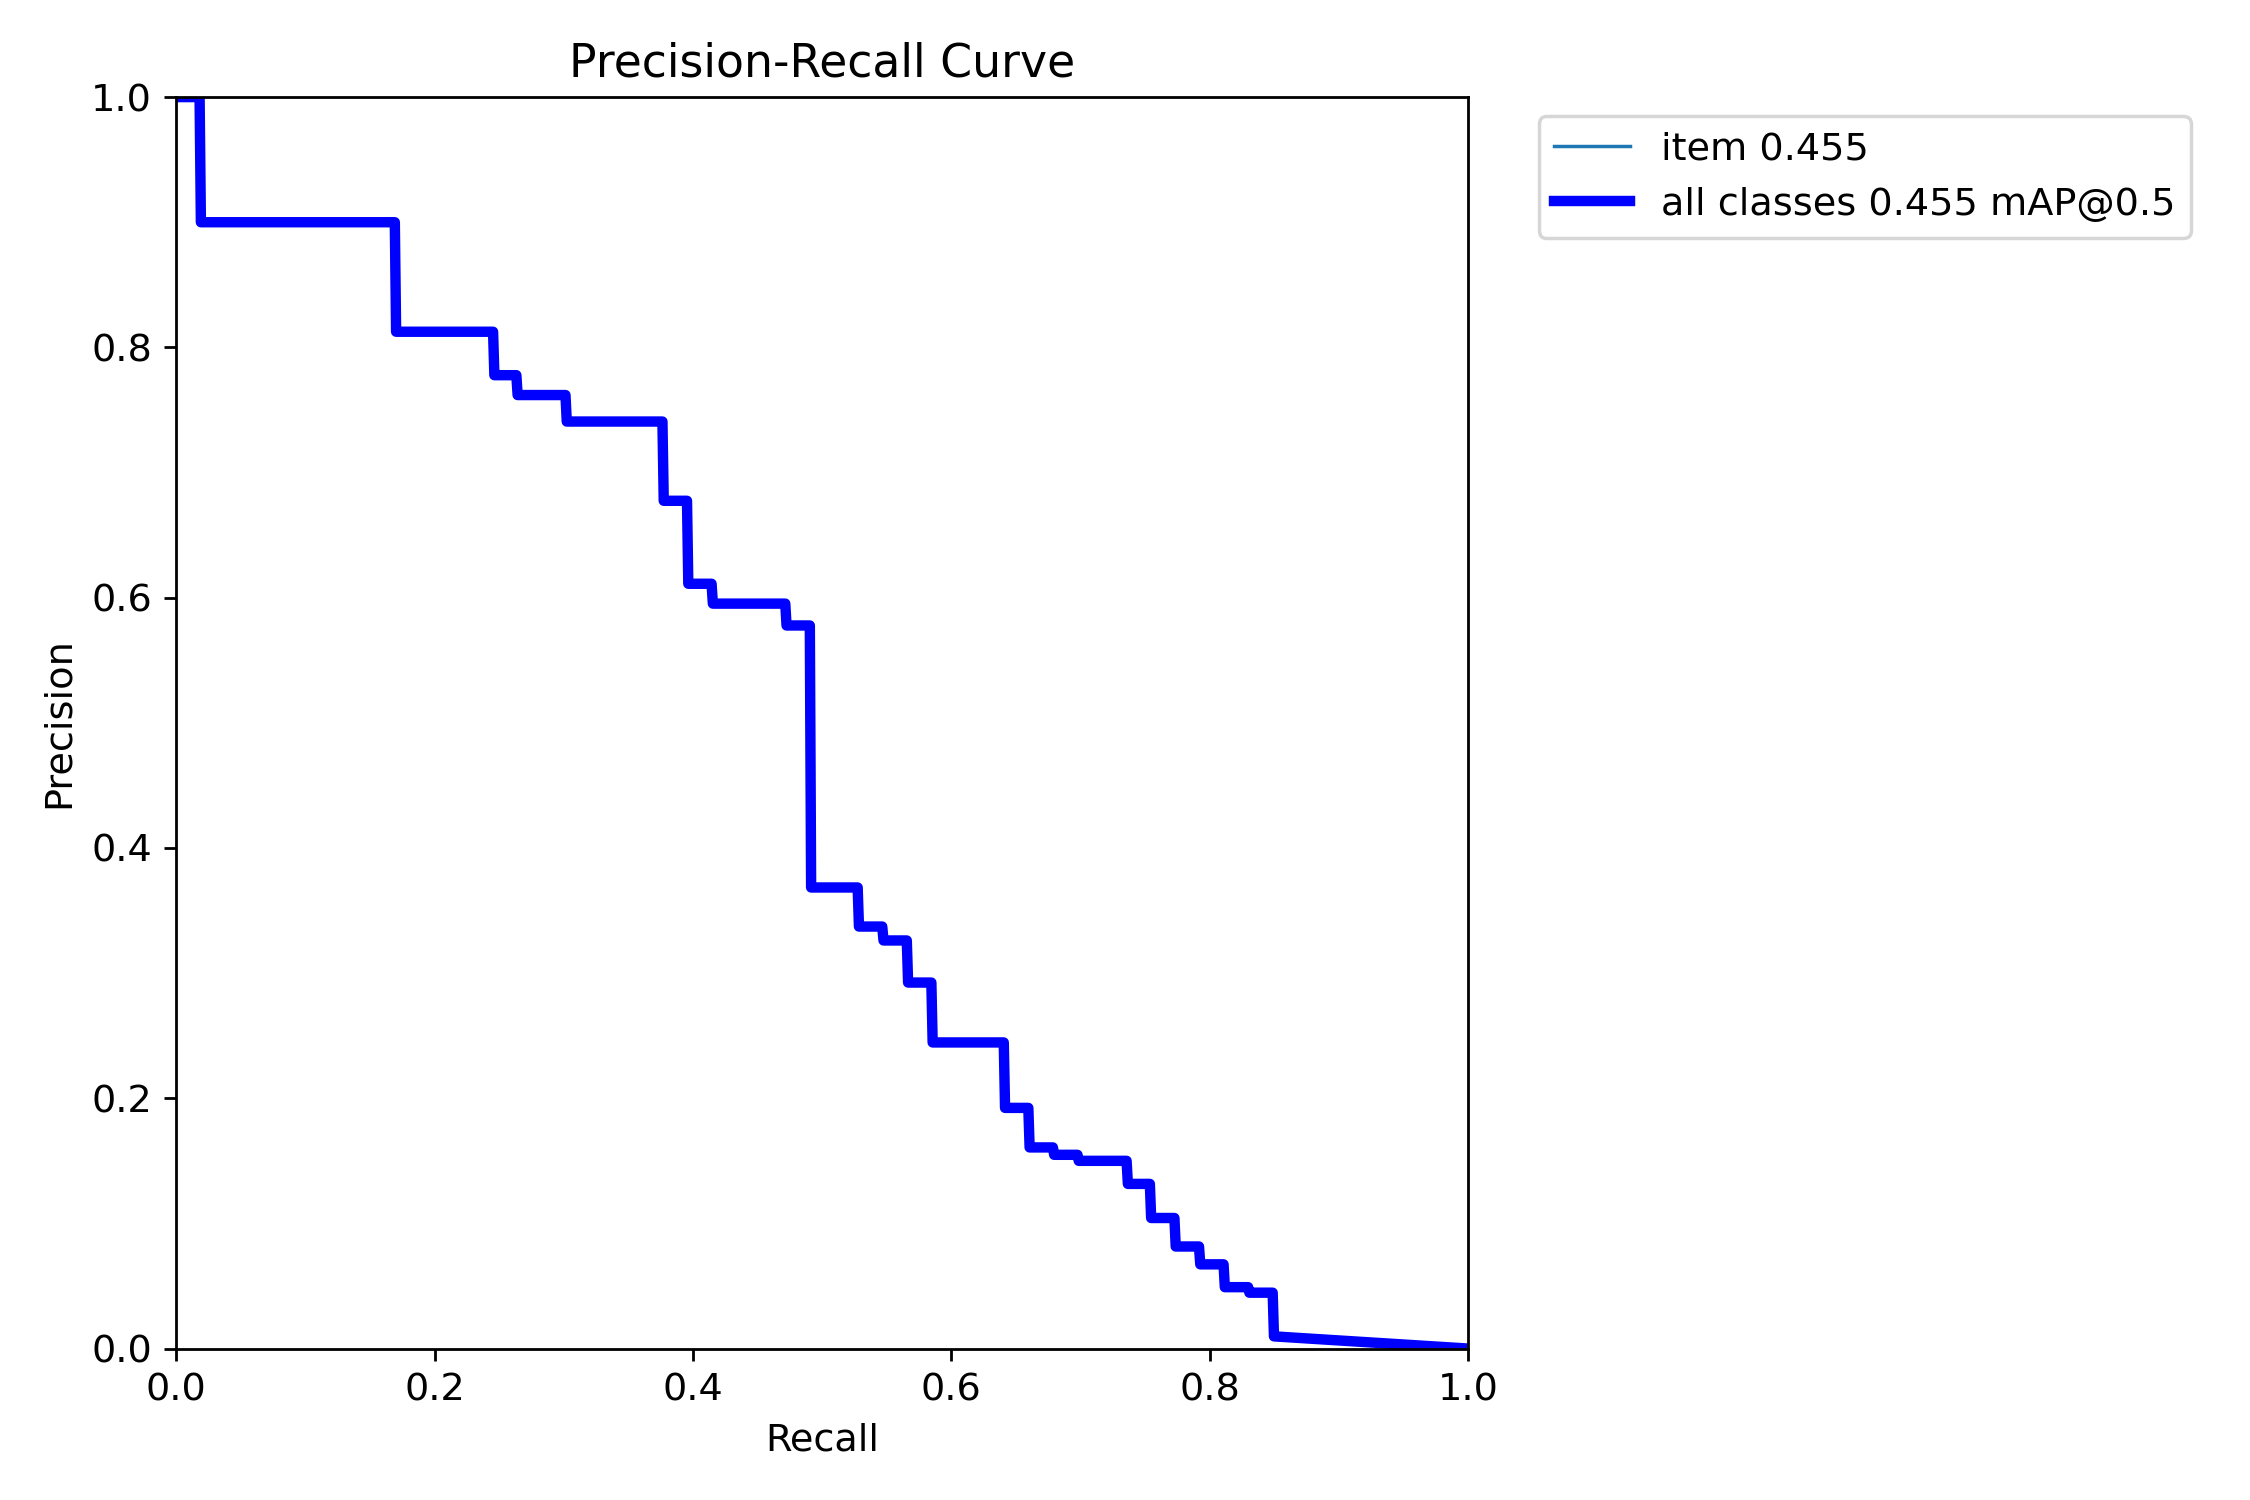

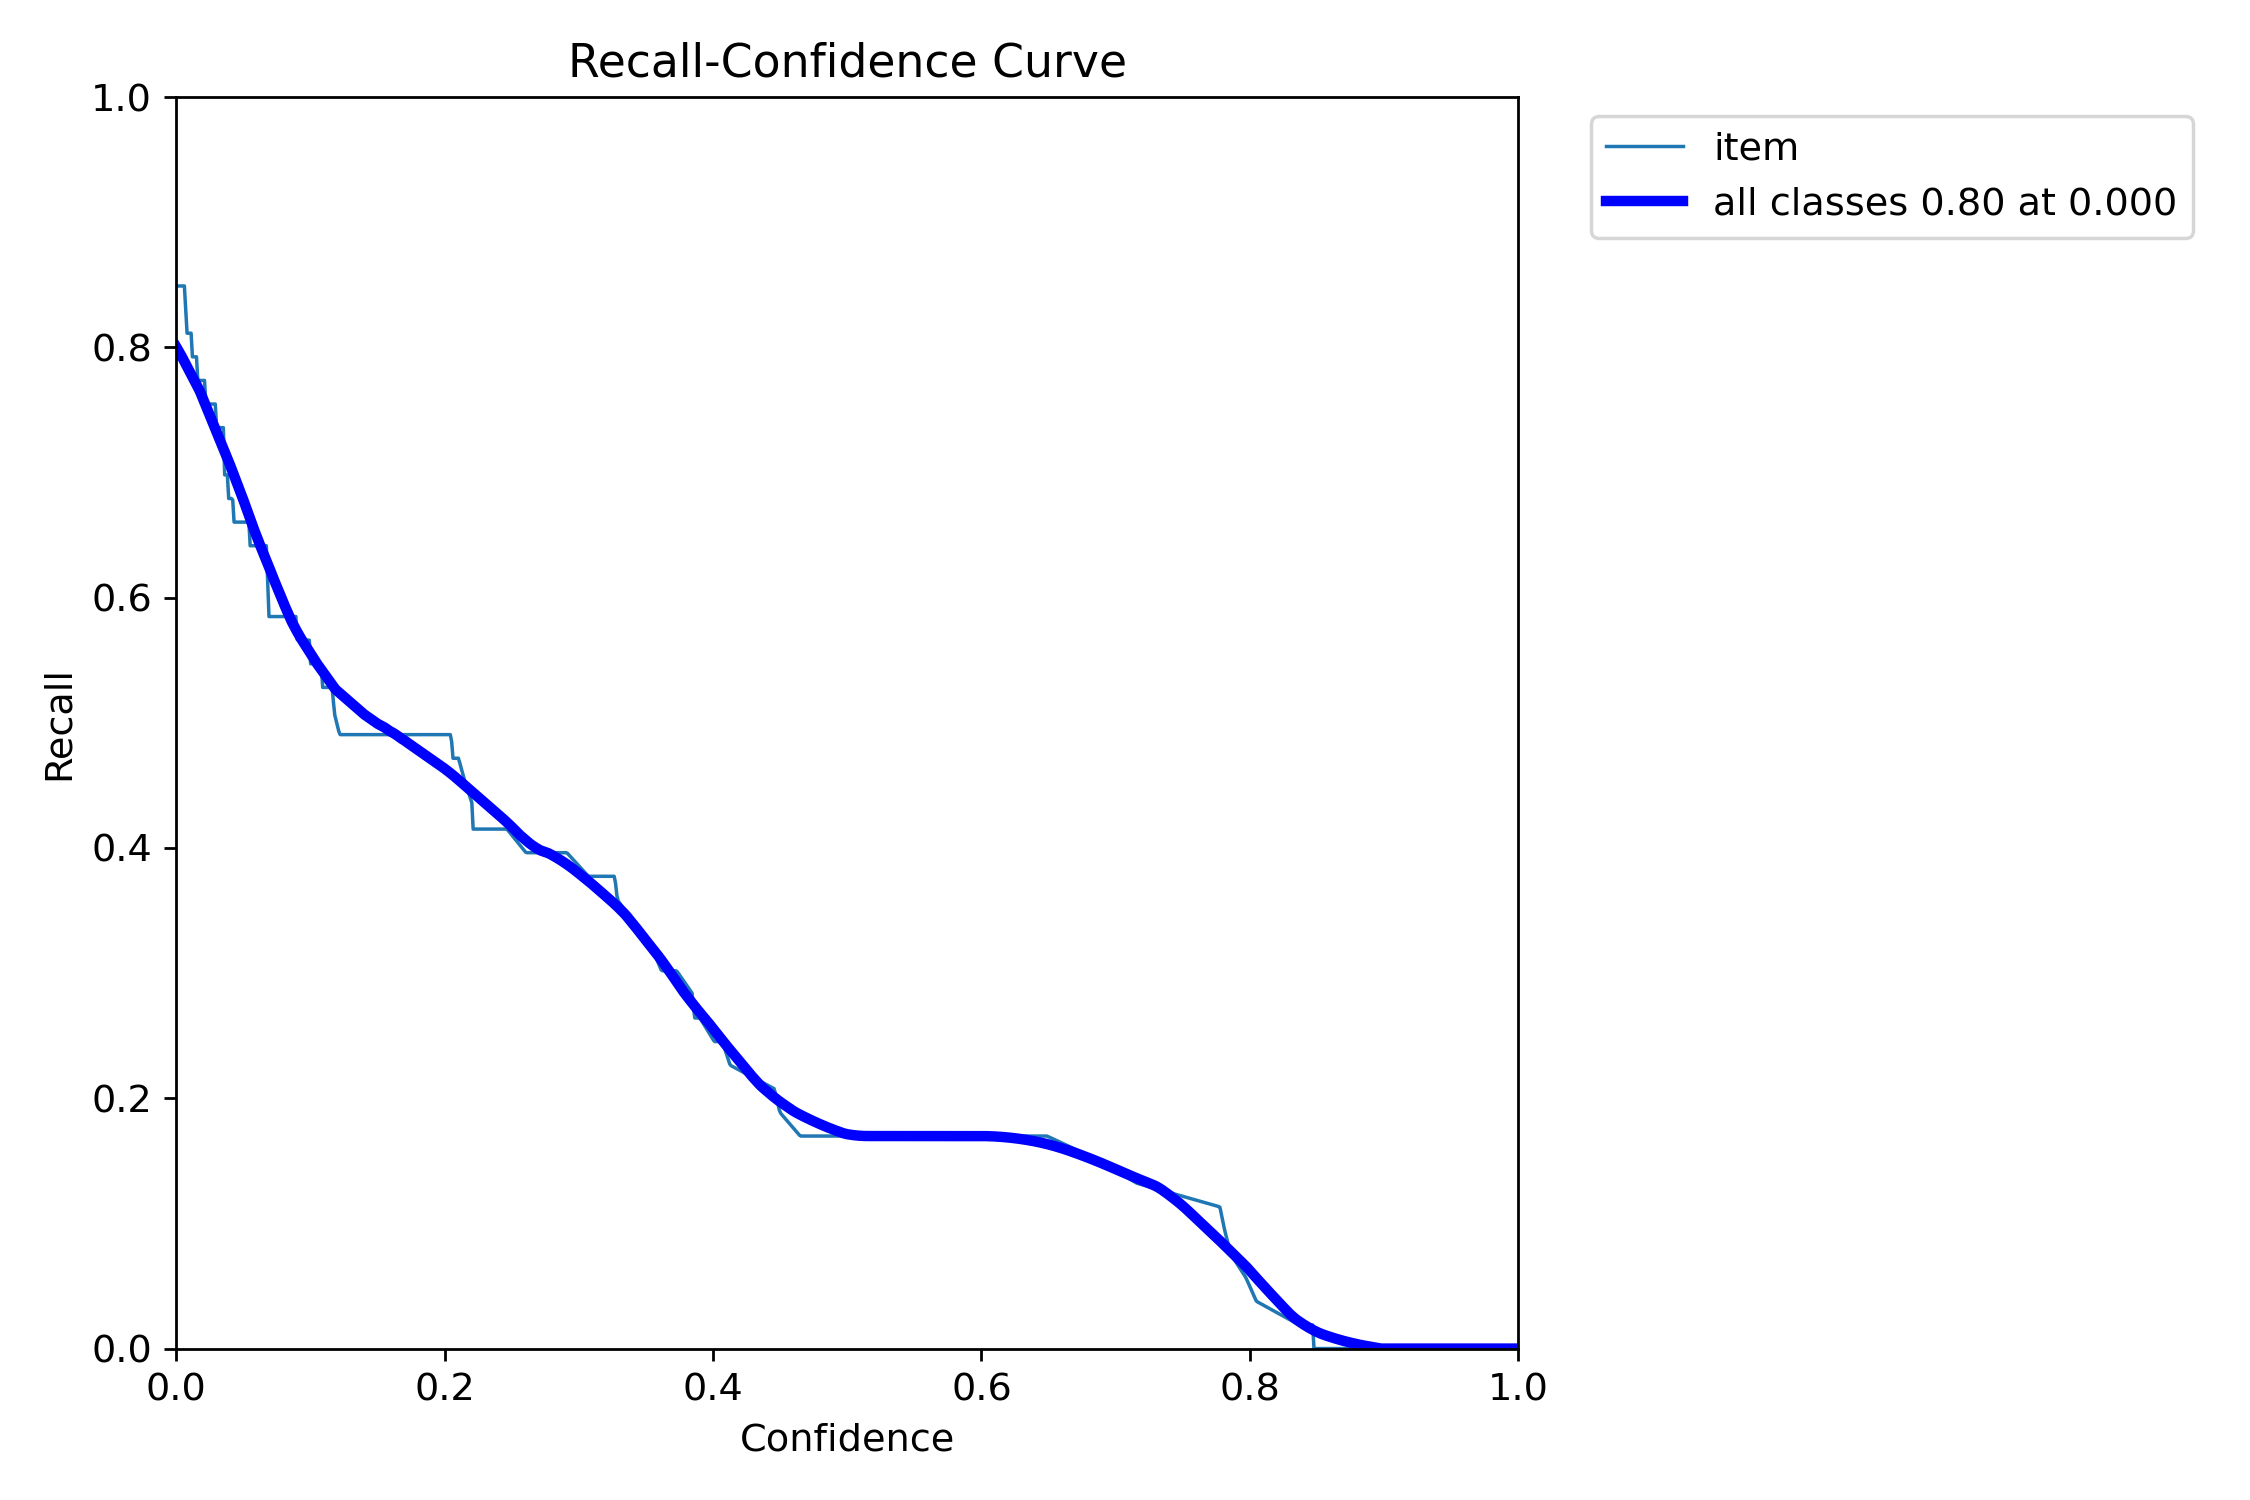

### *Confusion Matrix:*

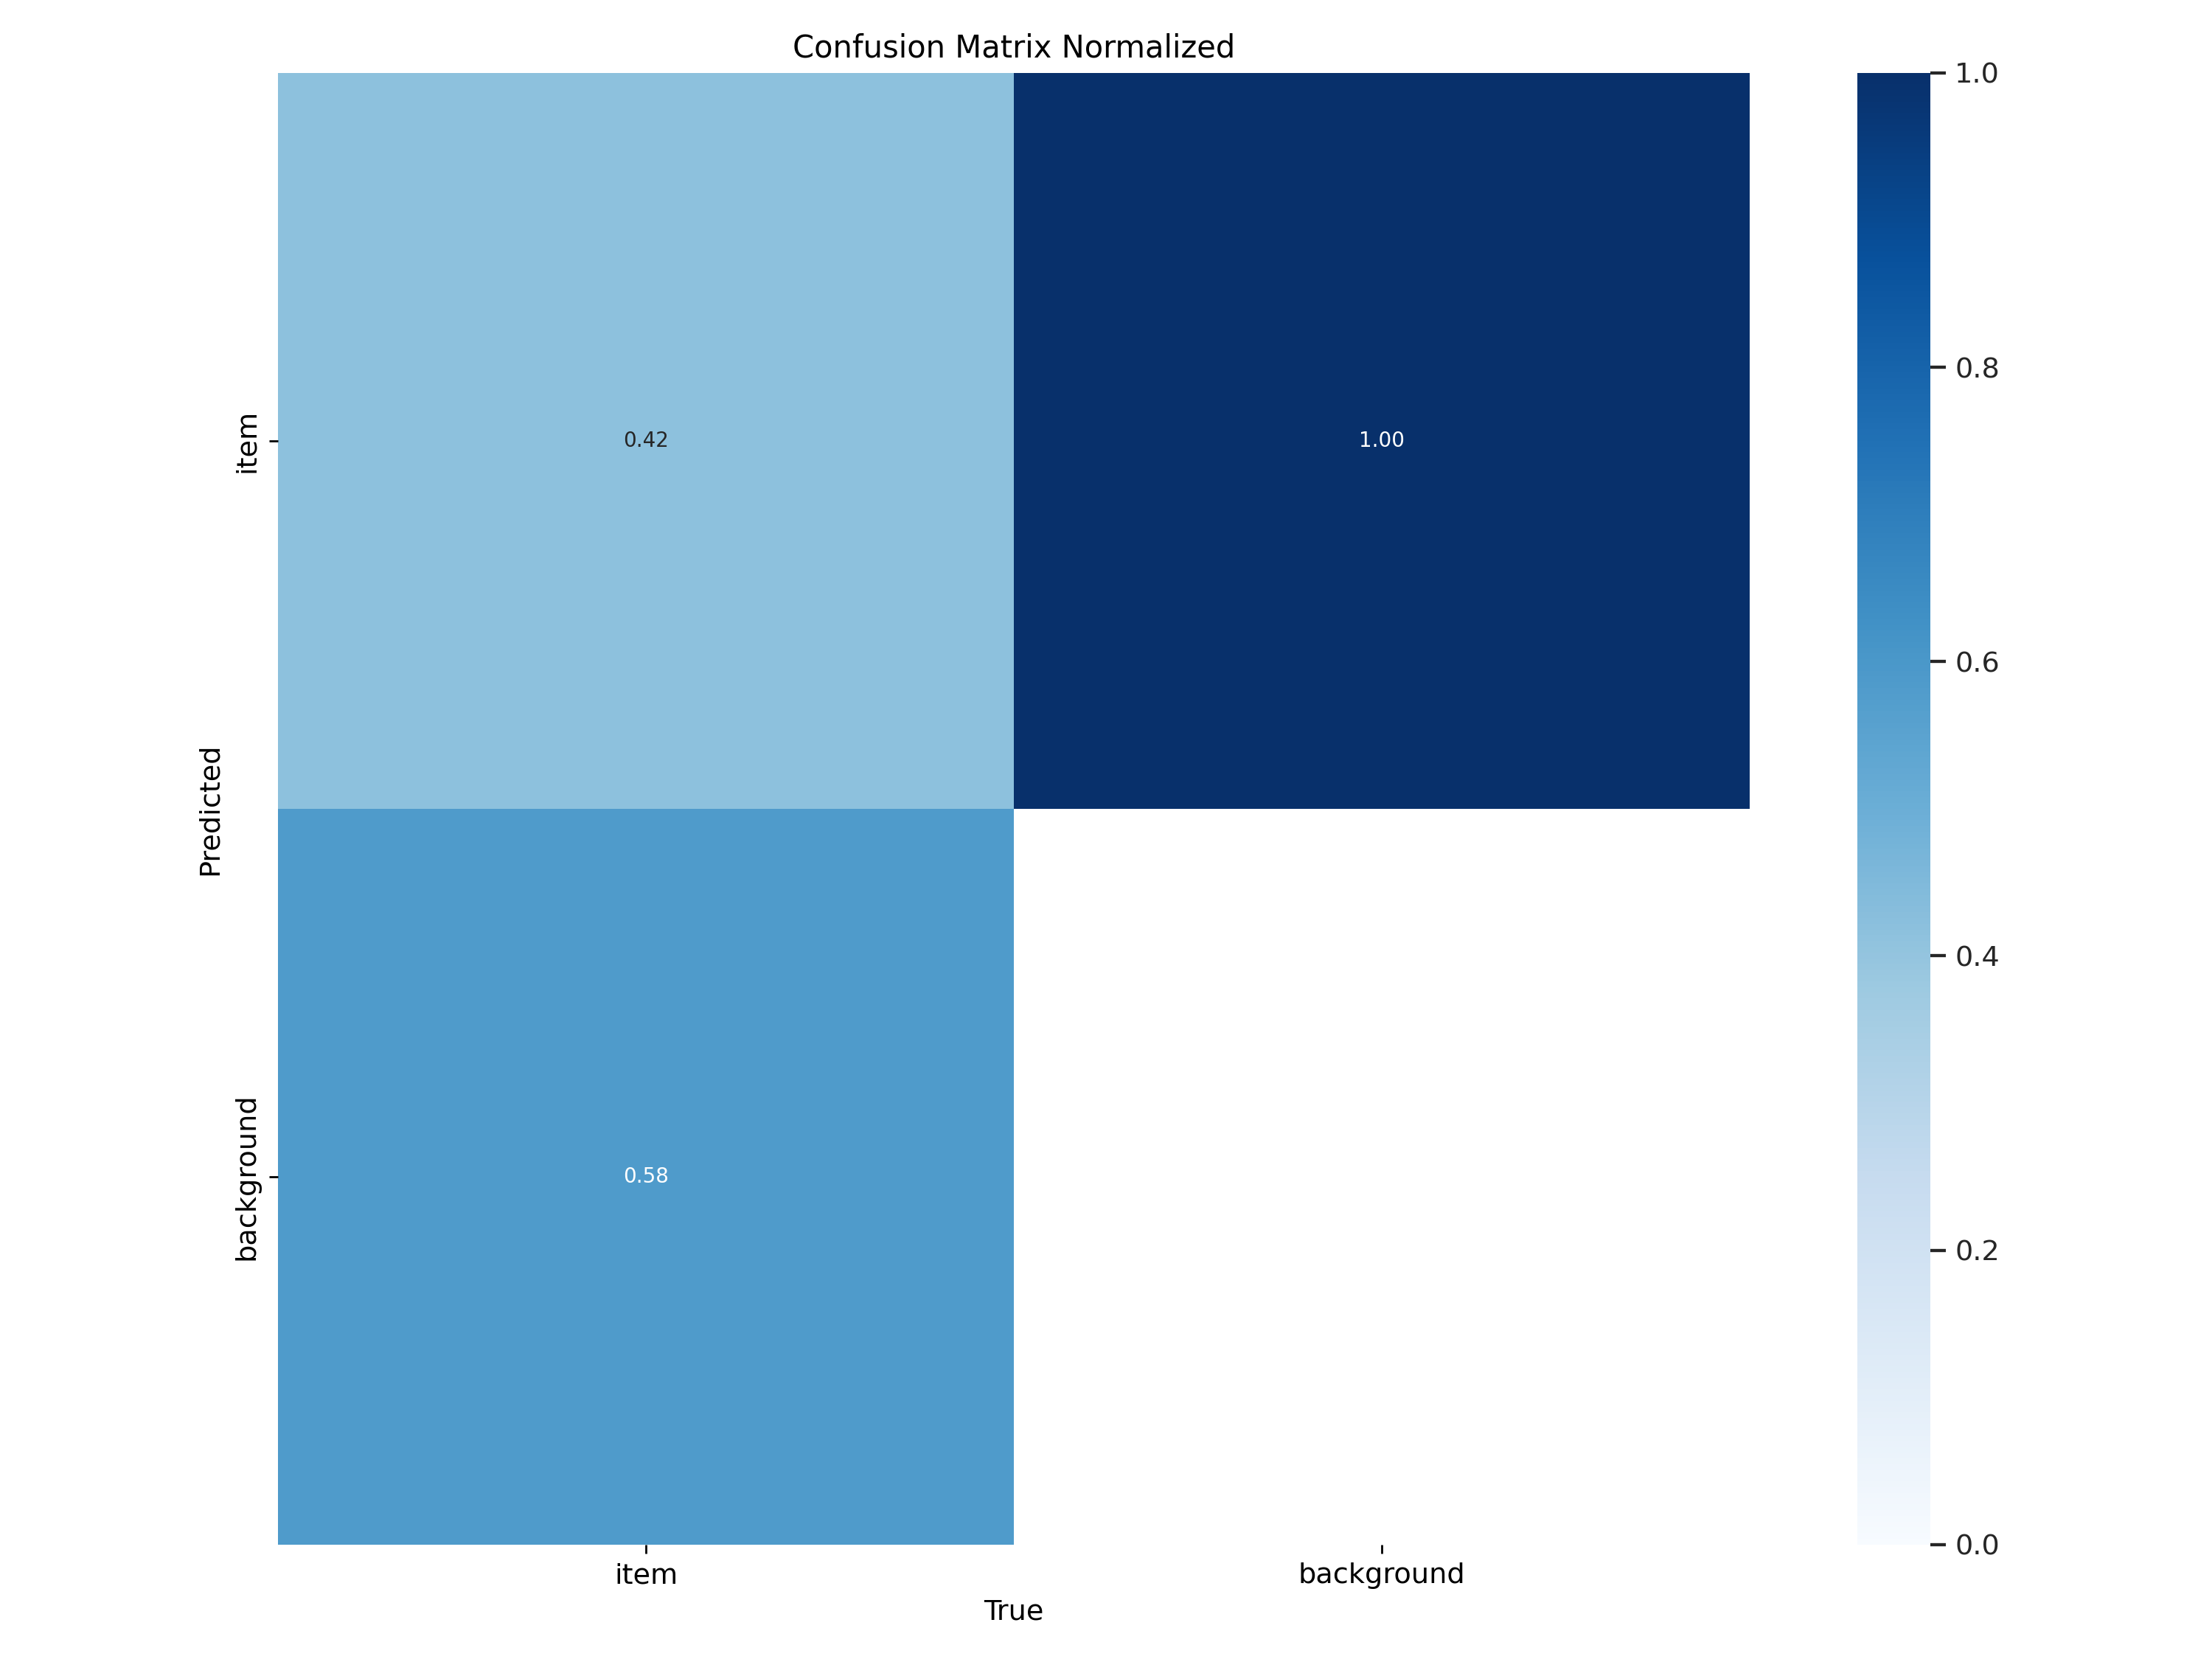

## Final thoughts  

Training on synthetic data **dramatically jump‑started** the real‑world model; however, limited page diversity capped performance (mAP ≈ 0.46). Scaling the synthetic set, adding distractor classes, and unfreezing more layers could boost generalisation.